# Brain Tumour Multi-Classification and Clustering

> Nikin Baidar  
> Submission (Phase 1): Fri Apr 15 2022  
> Submission (Phase 2): Fri May 06 2022

## Import everything necessary: Modules and Datasets!

* The myclassdef is a custom moudle saved in myclassdef.py in the project root.

In [34]:
# Py general
import numpy
import pandas
import os
import pathlib
import random

# Images/figures
from matplotlib import pyplot
from matplotlib import figure
from cv2 import imread
from cv2 import resize
from cv2 import IMREAD_GRAYSCALE

# Data perping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Models
from keras.models import Sequential
from keras.models import Model

# Layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# Activation functions
from keras.layers import ReLU
from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.layers import Softmax

# Callbacks
from keras.callbacks import EarlyStopping

# Optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# HP tuners
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Performancec evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Put the backend for the project in a separte script.
from myclassdef import CNNModel
from myclassdef import Images

# Import the dataset!
# tumours = Images(128, validation_ratio=0.21)
tumours = Images(180, validation_ratio=0.30)
tumours.shuffleData(mode='training')
tumours.getClassDistribution(mode='training')

## Phase 1
---

### 1. Convert Images to 2D numpy array and back. [Show examples]

<class 'numpy.ndarray'>
(128, 128, 1)



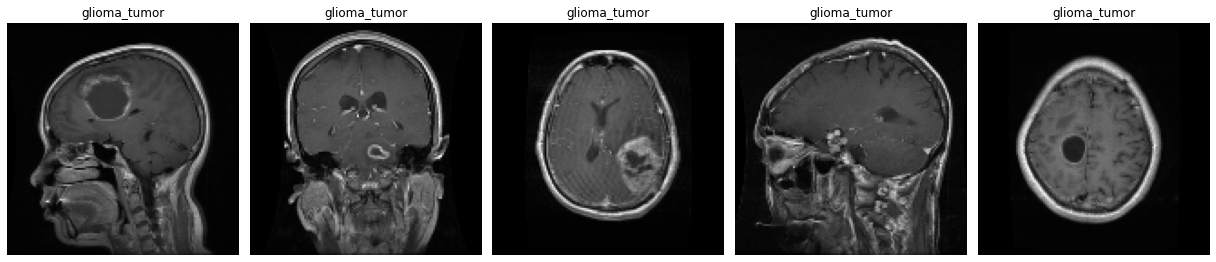

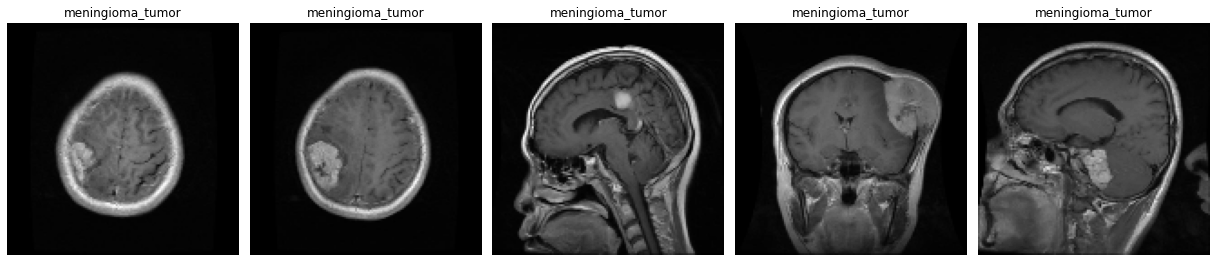

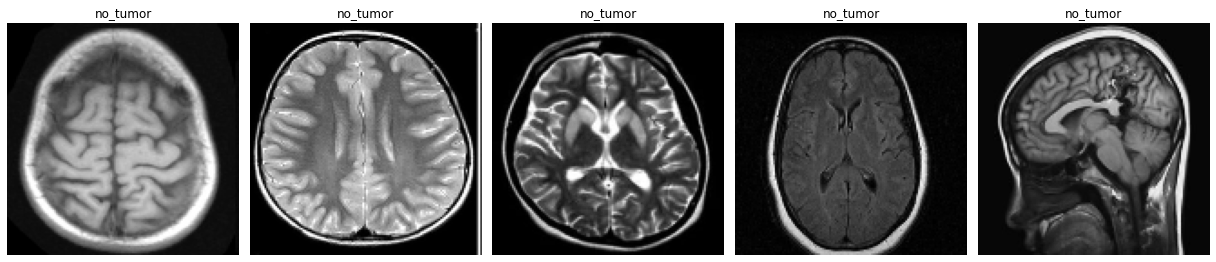

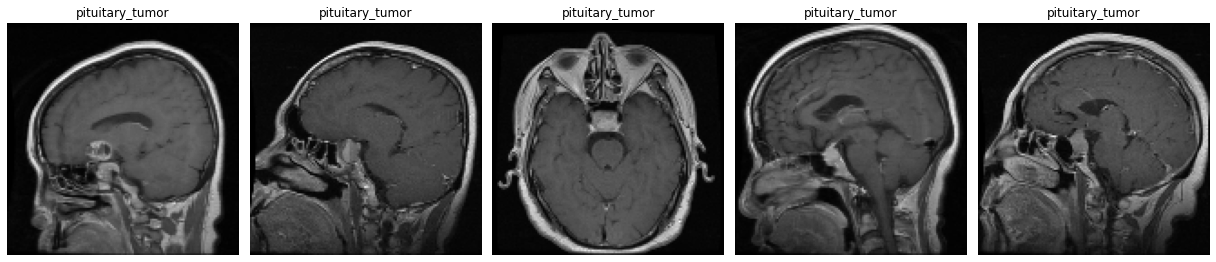

In [6]:
# Conversion to 2D numpy array
img = tumours.getRandomImage()
print(type(img))
print(img.shape)
print()

# And back
for key in tumours.labels:
    figure, axes = pyplot.subplots(1, 5, figsize=(17,17))
    for axis in axes.flatten():
        img = tumours.getRandomImage(mode='training', label=key)
        axis.imshow(img, cmap='gray')
        axis.set_title(key)
        axis.axis('off')
        pyplot.tight_layout()

### 2. Set up a basic CNN network to classify different tumor types. 

In [ ]:
BaseModel = CNNModel()
BaseModel.describe()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       80        
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        1168      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 64)          18496     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 64)        

In [118]:
%%time
BaseModel.train(
    tumours.x_train,
    tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=32,
    epochs=10,
    showProgress=True
)

Epoch 1/10
71/71 [==============================] - 6s 72ms/step - loss: 1.2104 - accuracy: 0.4495 - val_loss: 1.0843 - val_accuracy: 0.5174
Epoch 2/10
71/71 [==============================] - 5s 74ms/step - loss: 1.0021 - accuracy: 0.5673 - val_loss: 0.9858 - val_accuracy: 0.5987
Epoch 3/10
71/71 [==============================] - 5s 74ms/step - loss: 0.9015 - accuracy: 0.6370 - val_loss: 0.9317 - val_accuracy: 0.6020
Epoch 4/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8437 - accuracy: 0.6551 - val_loss: 0.8773 - val_accuracy: 0.6269
Epoch 5/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8012 - accuracy: 0.6665 - val_loss: 0.8412 - val_accuracy: 0.6766
Epoch 6/10
71/71 [==============================] - 5s 74ms/step - loss: 0.7568 - accuracy: 0.7168 - val_loss: 0.7867 - val_accuracy: 0.7065
Epoch 7/10
71/71 [==============================] - 5s 74ms/step - loss: 0.7062 - accuracy: 0.7530 - val_loss: 0.7590 - val_accuracy: 0.7280
Epoch 8/10
71

### 3. Report key metrics to quantify the performance of your neural network.

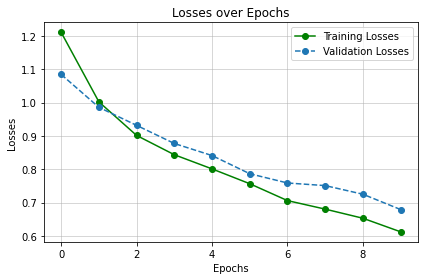

In [119]:
BaseModel.plotLosses()

#### Performance on the validation set.
---

,classes,value_count,distribution
0,glioma_tumor,183,0.303483
1,meningioma_tumor,180,0.298507
2,no_tumor,75,0.124378
3,pituitary_tumor,165,0.273632


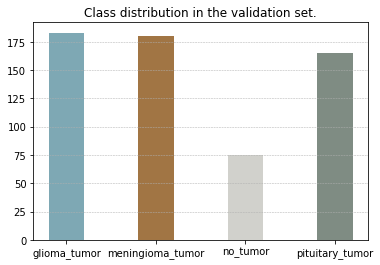

In [123]:
tumours.getClassDistribution(mode='validation', visualize=True)

In [124]:
BaseModel.evaluate()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           130                49         1                3
1  meningioma_tumor            28               114        25               13
2          no_tumor             1                 7        60                7
3   pituitary_tumor             3                 2         3              157

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       183
           1       0.66      0.63      0.65       180
           2       0.67      0.80      0.73        75
           3       0.87      0.95      0.91       165

    accuracy                           0.76       603
   macro avg       0.75      0.77      0.76       603
weighted avg       0.76      0.76      0.76       603



#### Performance on test set.
---

,classes,value_count,distribution
0,glioma_tumor,100,0.253807
1,meningioma_tumor,115,0.291878
2,no_tumor,105,0.266497
3,pituitary_tumor,74,0.187817


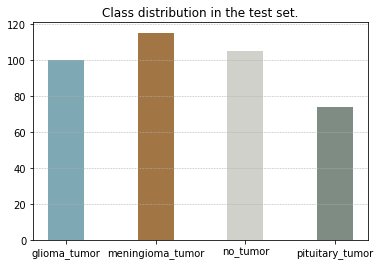

In [120]:
tumours.getClassDistribution(mode='test', visualize=True)

In [122]:
BaseModel.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor             9                10        69               12
1  meningioma_tumor             1                10        97                7
2          no_tumor             0                 8        85               12
3   pituitary_tumor             1                13        36               24

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.09      0.16       100
           1       0.24      0.09      0.13       115
           2       0.30      0.81      0.43       105
           3       0.44      0.32      0.37        74

    accuracy                           0.32       394
   macro avg       0.45      0.33      0.27       394
weighted avg       0.44      0.32      0.26       394



* The base model has a fairly good validation accuracy but the test  
accuracy is really low.

### 4. Set up a hyperparameter tuning mechanism

Set up a HP tuning mechanism to improve your performance metrics.  
Report performance on multiple scenarios tested. Different number  
of neurons/filter sizes? [At least 3 different types of hyperparams    
should be tested with at least 3 different values]

##### Test 0: Batch Size

CPU times: user 4min 59s, sys: 4.79 s, total: 5min 4s
Wall time: 52.5 s


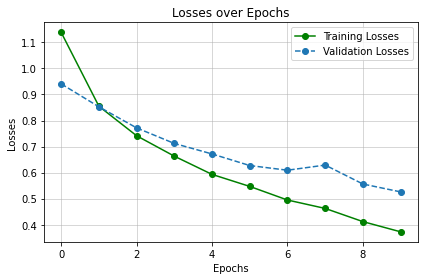

In [128]:
%%time
# Same architecture as the base model
alpha = CNNModel() 
alpha.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=16,
    validation_data=(tumours.x_val, tumours.y_val)
)
alpha.plotLosses()

In [129]:
alpha.evaluate()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           143                33         3                4
1  meningioma_tumor            32               122        12               14
2          no_tumor             5                13        53                4
3   pituitary_tumor             4                 2         2              157

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       183
           1       0.72      0.68      0.70       180
           2       0.76      0.71      0.73        75
           3       0.88      0.95      0.91       165

    accuracy                           0.79       603
   macro avg       0.78      0.78      0.78       603
weighted avg       0.78      0.79      0.79       603



* Reducing the batch size by half improved the f1 score by 2%.


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           141                32         0               10
1  meningioma_tumor            14               128        11               27
2          no_tumor             2                10        56                7
3   pituitary_tumor             0                 3         0              162

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       183
           1       0.74      0.71      0.73       180
           2       0.84      0.75      0.79        75
           3       0.79      0.98      0.87       165

    accuracy                           0.81       603
   macro avg       0.82      0.80      0.80       603
weighted avg       0.81      0.81      0.81       603

CPU times: user 5min 1s, sys: 6.8 s, total: 5min 8s
Wall time: 1min


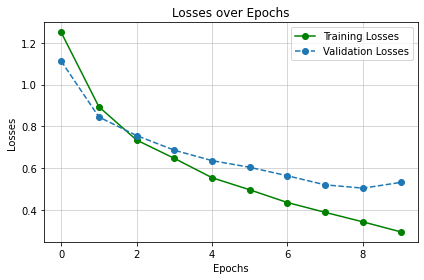

In [130]:
%%time
bravo = CNNModel() 
bravo.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=8,
    validation_data=(tumours.x_val, tumours.y_val)
)
bravo.plotLosses()

bravo.makePrediction(tumours.x_val)
bravo.getConfusionMatrix(tumours.y_val)
bravo.getClassificationReport(tumours.y_val)


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           130                50         0                3
1  meningioma_tumor            20               134        13               13
2          no_tumor             3                24        47                1
3   pituitary_tumor             3                10         0              152

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       183
           1       0.61      0.74      0.67       180
           2       0.78      0.63      0.70        75
           3       0.90      0.92      0.91       165

    accuracy                           0.77       603
   macro avg       0.78      0.75      0.76       603
weighted avg       0.78      0.77      0.77       603

CPU times: user 5min 3s, sys: 8.57 s, total: 5min 12s
Wall time: 49.5 s


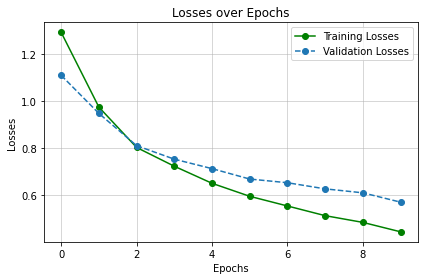

In [135]:
%%time
charlie = CNNModel() 
charlie.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val)
)
charlie.plotLosses()
charlie.evaluate()

* Increasing the batch size to 64 decrease the f1 score by almost 5%.  
To cope with this decrease depth and increase the number of epochs.

Epoch 1/20
36/36 [==============================] - 5s 122ms/step - loss: 1.2262 - accuracy: 0.4693 - val_loss: 1.1171 - val_accuracy: 0.5307
Epoch 2/20
36/36 [==============================] - 5s 142ms/step - loss: 1.0356 - accuracy: 0.5602 - val_loss: 1.0060 - val_accuracy: 0.5589
Epoch 3/20
36/36 [==============================] - 5s 140ms/step - loss: 0.9210 - accuracy: 0.6123 - val_loss: 0.9106 - val_accuracy: 0.5954
Epoch 4/20
36/36 [==============================] - 5s 138ms/step - loss: 0.8415 - accuracy: 0.6409 - val_loss: 0.8419 - val_accuracy: 0.6468
Epoch 5/20
36/36 [==============================] - 5s 137ms/step - loss: 0.7401 - accuracy: 0.7049 - val_loss: 0.7630 - val_accuracy: 0.6882
Epoch 6/20
36/36 [==============================] - 5s 137ms/step - loss: 0.6563 - accuracy: 0.7618 - val_loss: 0.7440 - val_accuracy: 0.7197
Epoch 7/20
36/36 [==============================] - 5s 136ms/step - loss: 0.6185 - accuracy: 0.7724 - val_loss: 0.7215 - val_accuracy: 0.7015
Epoch 

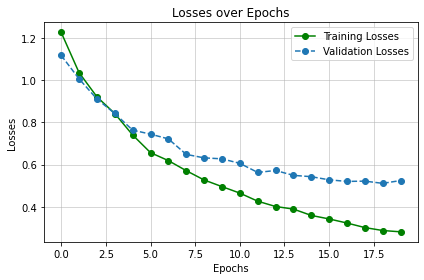

In [137]:
%%time
delta = CNNModel(depth=2) 
delta.train(
    tumours.x_train, tumours.y_train,
    epochs=20,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
delta.plotLosses()
delta.evaluate()

* Increasing the number of epochs seemed to have a positive affect on  
the overall model performance, although the computation time was greater.


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           142                37         0                4
1  meningioma_tumor             9               150        11               10
2          no_tumor             2                10        62                1
3   pituitary_tumor             1                 5         1              158

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       183
           1       0.74      0.83      0.79       180
           2       0.84      0.83      0.83        75
           3       0.91      0.96      0.93       165

    accuracy                           0.85       603
   macro avg       0.85      0.85      0.85       603
weighted avg       0.86      0.85      0.85       603

CPU times: user 12min 43s, sys: 15.1 s, total: 12min 58s
Wall time: 2min 2s


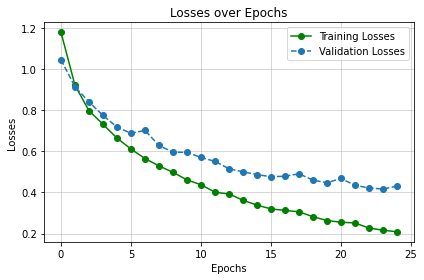

In [138]:
%%time
echo = CNNModel(depth=2) 
echo.train(
    tumours.x_train, tumours.y_train,
    epochs=25,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val),
)
echo.plotLosses()
echo.evaluate()

In [139]:
echo.describe()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       80        
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        1168      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 flat3 (Flatten)             (None, 2048)              0         
                                                                 
 dense4 (Dense)              (None, 8)               

##### Test 1: Filters, kernels and strides.

Epoch 1/10
23/23 [==============================] - 9s 398ms/step - loss: 1.3223 - accuracy: 0.3736 - val_loss: 1.1929 - val_accuracy: 0.5041
Epoch 2/10
23/23 [==============================] - 10s 422ms/step - loss: 1.1720 - accuracy: 0.5112 - val_loss: 1.1169 - val_accuracy: 0.5207
Epoch 3/10
23/23 [==============================] - 10s 426ms/step - loss: 1.0818 - accuracy: 0.5271 - val_loss: 1.0754 - val_accuracy: 0.5257
Epoch 4/10
23/23 [==============================] - 9s 413ms/step - loss: 1.0299 - accuracy: 0.5452 - val_loss: 1.0222 - val_accuracy: 0.5423
Epoch 5/10
23/23 [==============================] - 10s 417ms/step - loss: 0.9728 - accuracy: 0.5434 - val_loss: 0.9607 - val_accuracy: 0.5489
Epoch 6/10
23/23 [==============================] - 10s 415ms/step - loss: 0.9213 - accuracy: 0.5584 - val_loss: 0.9402 - val_accuracy: 0.5755
Epoch 7/10
23/23 [==============================] - 10s 424ms/step - loss: 0.8912 - accuracy: 0.6299 - val_loss: 0.8955 - val_accuracy: 0.6534
E

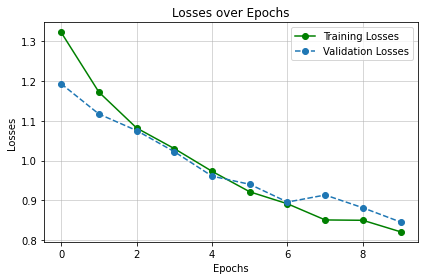

In [141]:
%%time
foxtrot = CNNModel(filters=16) 

foxtrot.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=100,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
foxtrot.plotLosses()
foxtrot.evaluate()

In [144]:
tumours.shuffleData()

Epoch 1/15
71/71 [==============================] - 56s 781ms/step - loss: 1.1955 - accuracy: 0.4477 - val_loss: 1.1225 - val_accuracy: 0.5489
Epoch 2/15
71/71 [==============================] - 55s 772ms/step - loss: 1.0303 - accuracy: 0.5761 - val_loss: 1.0076 - val_accuracy: 0.5920
Epoch 3/15
71/71 [==============================] - 55s 775ms/step - loss: 0.8882 - accuracy: 0.6392 - val_loss: 0.8913 - val_accuracy: 0.6285
Epoch 4/15
71/71 [==============================] - 54s 763ms/step - loss: 0.8010 - accuracy: 0.6811 - val_loss: 0.7885 - val_accuracy: 0.7081
Epoch 5/15
71/71 [==============================] - 55s 771ms/step - loss: 0.6914 - accuracy: 0.7481 - val_loss: 0.7364 - val_accuracy: 0.7181
Epoch 6/15
71/71 [==============================] - 54s 761ms/step - loss: 0.6466 - accuracy: 0.7653 - val_loss: 0.6810 - val_accuracy: 0.7413
Epoch 7/15
71/71 [==============================] - 54s 763ms/step - loss: 0.5674 - accuracy: 0.8019 - val_loss: 0.6084 - val_accuracy: 0.7778

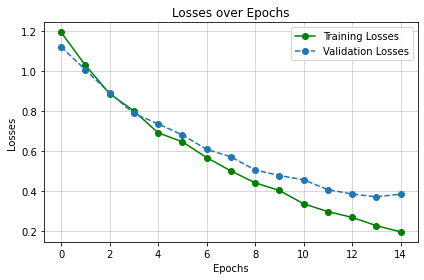

In [145]:
golf = CNNModel(filters=64, strides=2) 

golf.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
golf.plotLosses()
golf.evaluate()

Epoch 1/10
71/71 [==============================] - 54s 764ms/step - loss: 0.1665 - accuracy: 0.9727 - val_loss: 0.3495 - val_accuracy: 0.8905
Epoch 2/10
71/71 [==============================] - 54s 763ms/step - loss: 0.1568 - accuracy: 0.9713 - val_loss: 0.3368 - val_accuracy: 0.8922
Epoch 3/10
71/71 [==============================] - 54s 765ms/step - loss: 0.1246 - accuracy: 0.9819 - val_loss: 0.3584 - val_accuracy: 0.8789
Epoch 4/10
71/71 [==============================] - 54s 764ms/step - loss: 0.1076 - accuracy: 0.9841 - val_loss: 0.3263 - val_accuracy: 0.8922
Epoch 5/10
71/71 [==============================] - 54s 764ms/step - loss: 0.0990 - accuracy: 0.9859 - val_loss: 0.3496 - val_accuracy: 0.8955
Epoch 6/10
71/71 [==============================] - 54s 763ms/step - loss: 0.0838 - accuracy: 0.9876 - val_loss: 0.3559 - val_accuracy: 0.8939
Epoch 7/10
71/71 [==============================] - 54s 766ms/step - loss: 0.0763 - accuracy: 0.9899 - val_loss: 0.3284 - val_accuracy: 0.8972

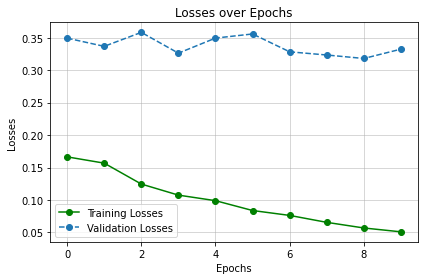

In [146]:
%%time
golf.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
golf.plotLosses()
golf.evaluate()

In [165]:
golf.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            18                37        38                7
1  meningioma_tumor             1               101        10                3
2          no_tumor             0                 1       103                1
3   pituitary_tumor            12                15        23               24

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.18      0.27       100
           1       0.66      0.88      0.75       115
           2       0.59      0.98      0.74       105
           3       0.69      0.32      0.44        74

    accuracy                           0.62       394
   macro avg       0.63      0.59      0.55       394
weighted avg       0.63      0.62      0.57       394



In [148]:
hotel = CNNModel(filters=8, kernel_size=5) 
hotel.describe()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        3216      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        12832     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 64)          51264     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 64)        

Epoch 1/15
71/71 [==============================] - 9s 123ms/step - loss: 1.1621 - accuracy: 0.4905 - val_loss: 1.0103 - val_accuracy: 0.5589
Epoch 2/15
71/71 [==============================] - 11s 156ms/step - loss: 0.9611 - accuracy: 0.5977 - val_loss: 0.8830 - val_accuracy: 0.6567
Epoch 3/15
71/71 [==============================] - 11s 160ms/step - loss: 0.8204 - accuracy: 0.6842 - val_loss: 0.7854 - val_accuracy: 0.7131
Epoch 4/15
71/71 [==============================] - 11s 159ms/step - loss: 0.6877 - accuracy: 0.7658 - val_loss: 0.7012 - val_accuracy: 0.7297
Epoch 5/15
71/71 [==============================] - 11s 157ms/step - loss: 0.6135 - accuracy: 0.7984 - val_loss: 0.6553 - val_accuracy: 0.7512
Epoch 6/15
71/71 [==============================] - 11s 158ms/step - loss: 0.5233 - accuracy: 0.8386 - val_loss: 0.5843 - val_accuracy: 0.7894
Epoch 7/15
71/71 [==============================] - 12s 165ms/step - loss: 0.4584 - accuracy: 0.8708 - val_loss: 0.5037 - val_accuracy: 0.8292


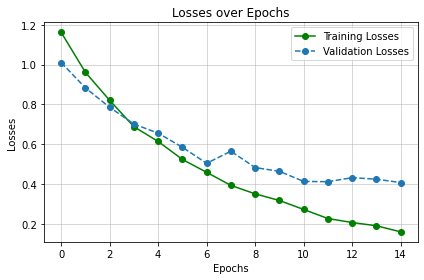

In [149]:
hotel.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
hotel.plotLosses()
hotel.evaluate()

Epoch 1/15
71/71 [==============================] - 12s 167ms/step - loss: 1.3586 - accuracy: 0.2894 - val_loss: 1.3390 - val_accuracy: 0.2985
Epoch 2/15
71/71 [==============================] - 14s 202ms/step - loss: 1.3516 - accuracy: 0.2770 - val_loss: 1.3394 - val_accuracy: 0.2736
Epoch 3/15
71/71 [==============================] - 14s 200ms/step - loss: 1.3524 - accuracy: 0.2691 - val_loss: 1.3393 - val_accuracy: 0.2985
Epoch 4/15
71/71 [==============================] - 14s 199ms/step - loss: 1.3519 - accuracy: 0.2814 - val_loss: 1.3421 - val_accuracy: 0.2736
Epoch 5/15
71/71 [==============================] - 14s 201ms/step - loss: 1.3512 - accuracy: 0.2964 - val_loss: 1.3389 - val_accuracy: 0.3035
Epoch 6/15
71/71 [==============================] - 14s 200ms/step - loss: 1.3512 - accuracy: 0.2867 - val_loss: 1.3396 - val_accuracy: 0.2736
Epoch 7/15
71/71 [==============================] - 14s 201ms/step - loss: 1.3516 - accuracy: 0.2748 - val_loss: 1.3393 - val_accuracy: 0.2736

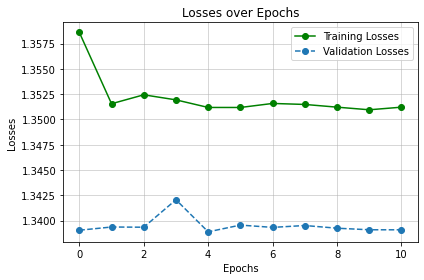

In [156]:
%%time
india = CNNModel(filters=4, kernel_size=7) 
india.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
india.plotLosses()
india.evaluate()

In [157]:
india.describe()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 4)       200       
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 8)         1576      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 16)        6288      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 16)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 32)          25120     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 32)        

##### Test 2: Optimizers and Learning Rates

Epoch 1/30
77/77 [==============================] - 40s 517ms/step - loss: 1.3173 - accuracy: 0.3788 - val_loss: 1.1898 - val_accuracy: 0.4756
Epoch 2/30
77/77 [==============================] - 41s 532ms/step - loss: 1.1409 - accuracy: 0.5035 - val_loss: 1.2631 - val_accuracy: 0.4548
Epoch 3/30
77/77 [==============================] - 41s 527ms/step - loss: 1.0174 - accuracy: 0.5433 - val_loss: 1.1692 - val_accuracy: 0.4687
Epoch 4/30
77/77 [==============================] - 41s 529ms/step - loss: 0.9259 - accuracy: 0.5970 - val_loss: 0.9188 - val_accuracy: 0.6450
Epoch 5/30
77/77 [==============================] - 41s 527ms/step - loss: 0.8305 - accuracy: 0.6544 - val_loss: 1.1940 - val_accuracy: 0.4200
Epoch 6/30
77/77 [==============================] - 41s 528ms/step - loss: 0.7749 - accuracy: 0.6667 - val_loss: 0.7974 - val_accuracy: 0.6497
Epoch 7/30
77/77 [==============================] - 41s 532ms/step - loss: 0.7038 - accuracy: 0.7048 - val_loss: 0.8204 - val_accuracy: 0.6288

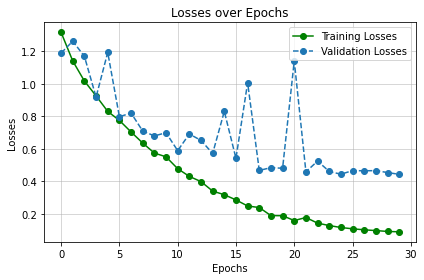

In [159]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100,
    decay_rate=0.9)

juliet = CNNModel(filters=16, kernel_size=5, optimizer=SGD(learning_rate=lr_schedule)) 
juliet.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
juliet.plotLosses()
juliet.evaluate()

* Running the final test on models with good val scores above did not  
seem to produce results anywhere close. So I decided to increase  
the validation ratio to 30%.

Epoch 1/30
63/63 [==============================] - 24s 376ms/step - loss: 1.3563 - accuracy: 0.3006 - val_loss: 1.3371 - val_accuracy: 0.3101
Epoch 2/30
63/63 [==============================] - 23s 372ms/step - loss: 1.3330 - accuracy: 0.3713 - val_loss: 1.2934 - val_accuracy: 0.4100
Epoch 3/30
63/63 [==============================] - 24s 378ms/step - loss: 1.2280 - accuracy: 0.5062 - val_loss: 1.2537 - val_accuracy: 0.4727
Epoch 4/30
63/63 [==============================] - 24s 379ms/step - loss: 1.0868 - accuracy: 0.5306 - val_loss: 1.0815 - val_accuracy: 0.4832
Epoch 5/30
63/63 [==============================] - 23s 370ms/step - loss: 0.9817 - accuracy: 0.5814 - val_loss: 1.0251 - val_accuracy: 0.5203
Epoch 6/30
63/63 [==============================] - 24s 382ms/step - loss: 0.9030 - accuracy: 0.6237 - val_loss: 0.9265 - val_accuracy: 0.5923
Epoch 7/30
63/63 [==============================] - 23s 370ms/step - loss: 0.8046 - accuracy: 0.6685 - val_loss: 0.8841 - val_accuracy: 0.6074

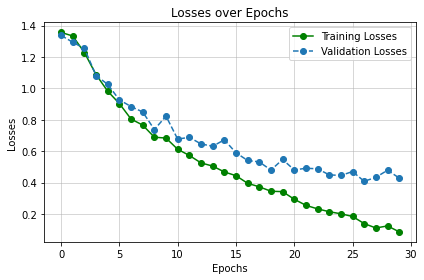

In [162]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.9)

kilo = CNNModel(filters=20, kernel_size=3, optimizer=SGD(learning_rate=lr_schedule)) 
kilo.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
kilo.plotLosses()
kilo.evaluate()

In [163]:
kilo.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            22                34        35                9
1  meningioma_tumor             2               100        10                3
2          no_tumor             3                 5        94                3
3   pituitary_tumor             2                24         1               47

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.22      0.34       100
           1       0.61      0.87      0.72       115
           2       0.67      0.90      0.77       105
           3       0.76      0.64      0.69        74

    accuracy                           0.67       394
   macro avg       0.70      0.65      0.63       394
weighted avg       0.69      0.67      0.63       394



* Increasing the validation ratio did increase the preformance on the  
test set to a certain degree for analogouse resutls on the validation  
set.

Epoch 1/30
16/16 [==============================] - 27s 2s/step - loss: 1.3555 - accuracy: 0.3071 - val_loss: 1.3473 - val_accuracy: 0.2695
Epoch 2/30
16/16 [==============================] - 26s 2s/step - loss: 1.3120 - accuracy: 0.3863 - val_loss: 1.1961 - val_accuracy: 0.4541
Epoch 3/30
16/16 [==============================] - 26s 2s/step - loss: 1.1874 - accuracy: 0.4559 - val_loss: 1.1116 - val_accuracy: 0.5099
Epoch 4/30
16/16 [==============================] - 26s 2s/step - loss: 1.1005 - accuracy: 0.4813 - val_loss: 1.1183 - val_accuracy: 0.4692
Epoch 5/30
16/16 [==============================] - 26s 2s/step - loss: 0.9783 - accuracy: 0.5565 - val_loss: 1.3355 - val_accuracy: 0.4657
Epoch 6/30
16/16 [==============================] - 26s 2s/step - loss: 0.9466 - accuracy: 0.5809 - val_loss: 0.9994 - val_accuracy: 0.5947
Epoch 7/30
16/16 [==============================] - 26s 2s/step - loss: 0.8778 - accuracy: 0.6207 - val_loss: 0.8582 - val_accuracy: 0.6249
Epoch 8/30
16/16 [==

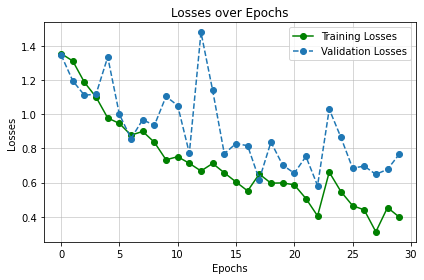

In [170]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.9,
    decay_steps=1000,
    decay_rate=0.9)

lima = CNNModel(filters=24, kernel_size=3,
                optimizer=SGD(learning_rate=lr_schedule)) 
lima.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    batch_size=32*4,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
lima.plotLosses()
lima.evaluate()

Epoch 1/40
63/63 [==============================] - 16s 250ms/step - loss: 1.2935 - accuracy: 0.3708 - val_loss: 1.2652 - val_accuracy: 0.4518
Epoch 2/40
63/63 [==============================] - 18s 282ms/step - loss: 1.0849 - accuracy: 0.5157 - val_loss: 1.0480 - val_accuracy: 0.5343
Epoch 3/40
63/63 [==============================] - 18s 281ms/step - loss: 0.9443 - accuracy: 0.5998 - val_loss: 0.9628 - val_accuracy: 0.5935
Epoch 4/40
63/63 [==============================] - 18s 280ms/step - loss: 0.8500 - accuracy: 0.6277 - val_loss: 1.0495 - val_accuracy: 0.5157
Epoch 5/40
63/63 [==============================] - 18s 278ms/step - loss: 0.7778 - accuracy: 0.6605 - val_loss: 0.8519 - val_accuracy: 0.6469
Epoch 6/40
63/63 [==============================] - 18s 280ms/step - loss: 0.7300 - accuracy: 0.6819 - val_loss: 0.8128 - val_accuracy: 0.6562
Epoch 7/40
63/63 [==============================] - 18s 280ms/step - loss: 0.6721 - accuracy: 0.7178 - val_loss: 0.8073 - val_accuracy: 0.6655

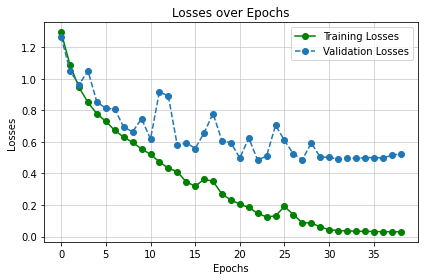

In [171]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.2,
    decay_steps=10000,
    decay_rate=0.8)

mike = CNNModel(filters=16, optimizer=SGD(learning_rate=lr_schedule)) 
mike.train(
    tumours.x_train, tumours.y_train,
    epochs=40,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
mike.plotLosses()
mike.evaluate()

Epoch 1/10
63/63 [==============================] - 8s 129ms/step - loss: 1.3110 - accuracy: 0.3728 - val_loss: 1.1624 - val_accuracy: 0.5052
Epoch 2/10
63/63 [==============================] - 10s 163ms/step - loss: 1.1499 - accuracy: 0.5241 - val_loss: 1.1390 - val_accuracy: 0.5029
Epoch 3/10
63/63 [==============================] - 10s 161ms/step - loss: 1.0877 - accuracy: 0.5441 - val_loss: 1.0888 - val_accuracy: 0.5285
Epoch 4/10
63/63 [==============================] - 10s 162ms/step - loss: 1.0391 - accuracy: 0.5669 - val_loss: 1.0616 - val_accuracy: 0.5412
Epoch 5/10
63/63 [==============================] - 10s 161ms/step - loss: 0.9877 - accuracy: 0.5893 - val_loss: 1.0004 - val_accuracy: 0.5830
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.9282 - accuracy: 0.6227 - val_loss: 0.9480 - val_accuracy: 0.6039
Epoch 7/10
63/63 [==============================] - 10s 161ms/step - loss: 0.8746 - accuracy: 0.6476 - val_loss: 0.8921 - val_accuracy: 0.6504


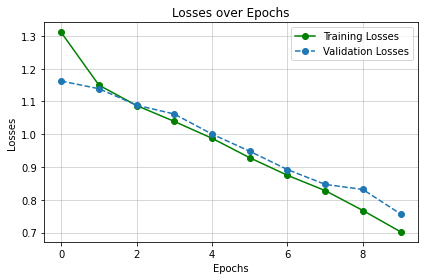

In [173]:
%%time
november = CNNModel(depth=4, optimizer=Adam(learning_rate=0.0008))
november.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=10,
    showProgress=True
)
november.plotLosses()
november.evaluate()

Epoch 1/30
63/63 [==============================] - 10s 154ms/step - loss: 1.3427 - accuracy: 0.3136 - val_loss: 1.3039 - val_accuracy: 0.4774
Epoch 2/30
63/63 [==============================] - 10s 162ms/step - loss: 1.2401 - accuracy: 0.5177 - val_loss: 1.2225 - val_accuracy: 0.4994
Epoch 3/30
63/63 [==============================] - 10s 161ms/step - loss: 1.1917 - accuracy: 0.5326 - val_loss: 1.1882 - val_accuracy: 0.5145
Epoch 4/30
63/63 [==============================] - 10s 161ms/step - loss: 1.1656 - accuracy: 0.5376 - val_loss: 1.1715 - val_accuracy: 0.5203
Epoch 5/30
63/63 [==============================] - 10s 164ms/step - loss: 1.1290 - accuracy: 0.5495 - val_loss: 1.1205 - val_accuracy: 0.5470
Epoch 6/30
63/63 [==============================] - 10s 162ms/step - loss: 1.1087 - accuracy: 0.5495 - val_loss: 1.1092 - val_accuracy: 0.5563
Epoch 7/30
63/63 [==============================] - 10s 161ms/step - loss: 1.0788 - accuracy: 0.5660 - val_loss: 1.0765 - val_accuracy: 0.5575

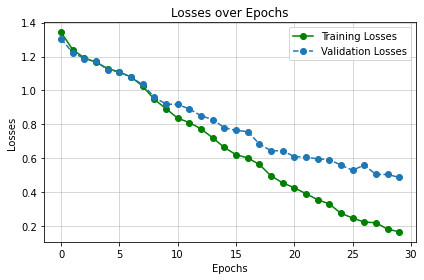

In [182]:
%%time
oscar = CNNModel(depth=4, optimizer=Adam(learning_rate=0.0009))
oscar.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)
oscar.plotLosses()
oscar.evaluate()

In [185]:
oscar.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            22                40        29                9
1  meningioma_tumor             0                92        15                8
2          no_tumor             3                 5        93                4
3   pituitary_tumor             0                38         1               35

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.22      0.35       100
           1       0.53      0.80      0.63       115
           2       0.67      0.89      0.77       105
           3       0.62      0.47      0.54        74

    accuracy                           0.61       394
   macro avg       0.68      0.59      0.57       394
weighted avg       0.67      0.61      0.58       394



Epoch 1/20
63/63 [==============================] - 40s 636ms/step - loss: 1.1991 - accuracy: 0.4385 - val_loss: 1.1073 - val_accuracy: 0.5447
Epoch 2/20
63/63 [==============================] - 41s 645ms/step - loss: 1.0133 - accuracy: 0.5859 - val_loss: 1.0658 - val_accuracy: 0.5552
Epoch 3/20
63/63 [==============================] - 41s 647ms/step - loss: 0.9236 - accuracy: 0.6242 - val_loss: 0.9786 - val_accuracy: 0.5772
Epoch 4/20
63/63 [==============================] - 40s 636ms/step - loss: 0.8601 - accuracy: 0.6635 - val_loss: 0.8711 - val_accuracy: 0.6678
Epoch 5/20
63/63 [==============================] - 40s 635ms/step - loss: 0.8104 - accuracy: 0.6854 - val_loss: 0.8679 - val_accuracy: 0.6225
Epoch 6/20
63/63 [==============================] - 40s 637ms/step - loss: 0.7629 - accuracy: 0.7068 - val_loss: 0.8219 - val_accuracy: 0.6609
Epoch 7/20
63/63 [==============================] - 40s 638ms/step - loss: 0.7311 - accuracy: 0.7218 - val_loss: 0.7774 - val_accuracy: 0.6911

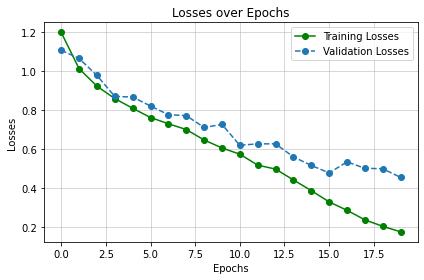

In [187]:
%%time
papa = CNNModel(depth=4, filters=32, optimizer=Adam(learning_rate=0.0009))
papa.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=20,
    showProgress=True
)
papa.plotLosses()
papa.evaluate()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       136       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        2064      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        8224      
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)       

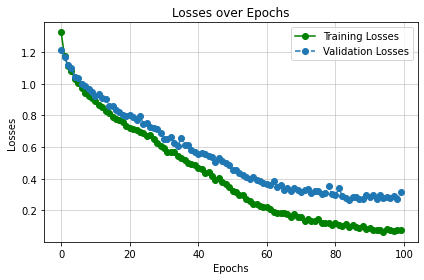

In [10]:
%%time
quebec = CNNModel(
    depth=3,
    kernel_size=4,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

quebec.describe()

quebec.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=100,
    showProgress=True
)

quebec.plotLosses()
quebec.evaluate()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        3216      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        12832     
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)        0

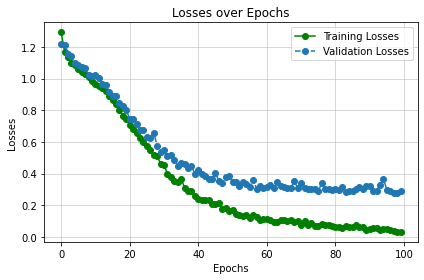

In [9]:
%%time
romeo = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

romeo.describe()

romeo.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=64,
    epochs=100,
    showProgress=True
)

romeo.plotLosses()
romeo.evaluate()

In [ ]:
romeo.finalTest()

##### Cross-validation

In [11]:
sierra = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

In [12]:
sierra.describe()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 8)       208       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 16)        3216      
                                                                 
 drop1 (Dropout)             (None, 90, 90, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 32)        12832     
                                                                 
 drop2 (Dropout)             (None, 23, 23, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 32)       

###### Show casing different sets for cross-validation.

In [ ]:
%%time
folds = 5

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    # tumours.shuffleData(mode='training')
    # tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('Starting cross-validation in fold {}'.format(i))
    print('='*35, end='\n'*2)
    print(f'Training on {training_data_points} datapoints and validating in' \
          f'{validation_data_points}')
    print(numpy.argmax(tumours.y_val, axis=1))
    print()
        
    

###### Performing cross validation on 5 folds.

In [13]:
%%time
folds = 5

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    
    sierra.train(
        tumours.x_train, tumours.y_train,
        validation_data=(tumours.x_val, tumours.y_val),
        batch_size=64,
        epochs=100,
    )

    print('Training complete! fetching performance report...')
    
    accuracy__[i] = max(sierra.getDataPoints(mode='accuracy'))
    sierra.makePrediction(tumours.x_val)
    sierra.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 2296 and validating in 574 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       162
           1       0.86      0.93      0.89       165
           2       0.93      0.90      0.92        92
           3       0.95      1.00      0.97       155

    accuracy                           0.93       574
   macro avg       0.93      0.93      0.93       574
weighted avg       0.93      0.93      0.93       574

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 2296 and validating in 574 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

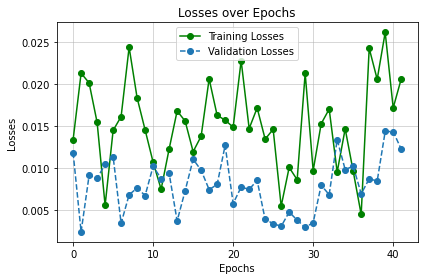

In [14]:
sierra.plotLosses()

In [15]:
sierra.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            18                33        46                3
1  meningioma_tumor             0               115         0                0
2          no_tumor             0                 0       105                0
3   pituitary_tumor             0                15         8               51

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       100
           1       0.71      1.00      0.83       115
           2       0.66      1.00      0.80       105
           3       0.94      0.69      0.80        74

    accuracy                           0.73       394
   macro avg       0.83      0.72      0.68       394
weighted avg       0.81      0.73      0.68       394



###### Performing cross-validation on 3 folds.

In [17]:
tango = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

In [18]:
%%time
folds = 3

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.3333, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    # Datapoint counts
    validation_data_points = tumours.y_val.shape[0]
    training_data_points   = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    
    tango.train(
        tumours.x_train, tumours.y_train,
        validation_data=(tumours.x_val, tumours.y_val),
        batch_size=64,
        epochs=100,
    )

    print('Training complete! fetching performance report...')
    
    accuracy__[i] = max(tango.getDataPoints(mode='accuracy'))
    tango.makePrediction(tumours.x_val)
    tango.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 1913 and validating in 957 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       274
           1       0.89      0.85      0.87       275
           2       0.91      0.82      0.86       115
           3       0.94      0.98      0.96       293

    accuracy                           0.91       957
   macro avg       0.91      0.90      0.90       957
weighted avg       0.91      0.91      0.91       957

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 1913 and validating in 957 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

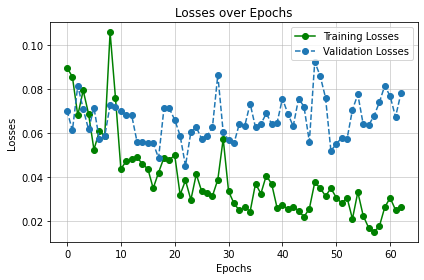

In [19]:
tango.plotLosses()

In [21]:
tango.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            19                51        24                6
1  meningioma_tumor             0               113         1                1
2          no_tumor             0                 3       101                1
3   pituitary_tumor             2                10        12               50

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.19      0.31       100
           1       0.64      0.98      0.77       115
           2       0.73      0.96      0.83       105
           3       0.86      0.68      0.76        74

    accuracy                           0.72       394
   macro avg       0.78      0.70      0.67       394
weighted avg       0.77      0.72      0.67       394



* If your model isn't generalizing over the training, the test and the  
validation sets performing a cross-validation check definitely seems  
to help.

##### Test 3: Experimenting 

In [29]:
uniform = CNNModel(
    depth=4,
    kernel_size=3,
    filters=16,
    strides=2,
    optimizer=Adam()
)

uniform.describe()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 16)      160       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 32)        4640      
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 3, 3, 128)        

Epoch 1/50
60/60 [==============================] - 10s 159ms/step - loss: 1.3704 - accuracy: 0.3586 - val_loss: 1.3035 - val_accuracy: 0.5016
Epoch 2/50
60/60 [==============================] - 9s 154ms/step - loss: 1.2844 - accuracy: 0.4997 - val_loss: 1.2774 - val_accuracy: 0.4932
Epoch 3/50
60/60 [==============================] - 9s 154ms/step - loss: 1.2507 - accuracy: 0.5060 - val_loss: 1.2361 - val_accuracy: 0.5235
Epoch 4/50
60/60 [==============================] - 9s 154ms/step - loss: 1.2384 - accuracy: 0.4997 - val_loss: 1.1853 - val_accuracy: 0.5057
Epoch 5/50
60/60 [==============================] - 9s 155ms/step - loss: 1.1295 - accuracy: 0.5233 - val_loss: 1.1085 - val_accuracy: 0.5329
Epoch 6/50
60/60 [==============================] - 9s 156ms/step - loss: 1.0813 - accuracy: 0.5588 - val_loss: 1.0849 - val_accuracy: 0.5632
Epoch 7/50
60/60 [==============================] - 9s 155ms/step - loss: 1.0521 - accuracy: 0.5766 - val_loss: 1.0729 - val_accuracy: 0.5528
Epoch

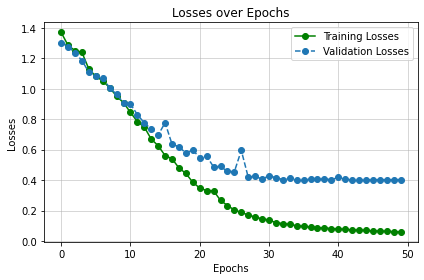

In [30]:
uniform.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=50,
    showProgress=True
)

uniform.plotLosses()
uniform.evaluate()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 32)      160       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 64)        8256      
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 128)       32896     
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 256)         131328    
                                                                 
 pool3 (MaxPooling2D)        (None, 3, 3, 256)        

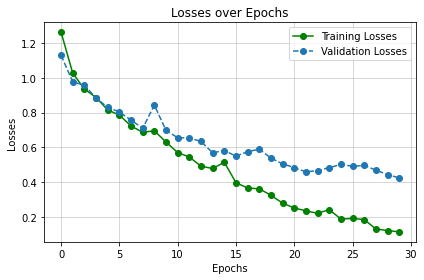

In [12]:
victor = CNNModel(
    depth=4,
    kernel_size=2,
    filters=32,
    optimizer=Adam()
)

victor.describe()
victor.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)

victor.plotLosses()
victor.evaluate()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 36)      936       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 72)        64872     
                                                                 
 drop1 (Dropout)             (None, 90, 90, 72)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 72)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 144)       259344    
                                                                 
 drop2 (Dropout)             (None, 23, 23, 144)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 144)      

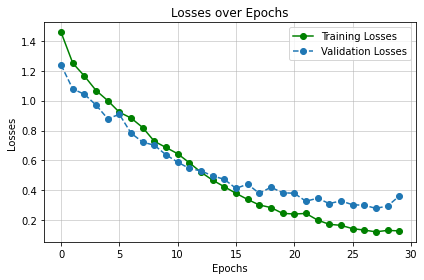

In [10]:
whisky = CNNModel(
    depth=3,
    kernel_size=5,
    filters=36,
    addDropouts=True,
    optimizer=Adam()
)

whisky.describe()
whisky.train(
    tumours.x_train, tumours.y_train,
    class_weight= {0:2, 1:1, 2: 1, 3:1},
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)

whisky.plotLosses()
whisky.evaluate()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 36)      936       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 72)        64872     
                                                                 
 drop1 (Dropout)             (None, 90, 90, 72)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 72)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 144)       259344    
                                                                 
 drop2 (Dropout)             (None, 23, 23, 144)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 144)      

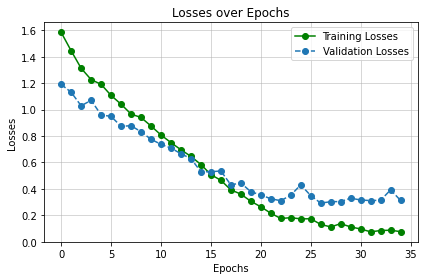

In [23]:
xray = CNNModel(
    depth=3,
    kernel_size=5,
    filters=36,
    addDropouts=True,
    optimizer=Adam()
)

xray.describe()
xray.train(
    tumours.x_train, tumours.y_train,
    class_weight= {0:2, 1:1, 2: 1, 3:1.5},
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=35,
    showProgress=True
)

xray.plotLosses()
xray.evaluate()

In [7]:
yankee = CNNModel(
    depth=3,
    kernel_size=5,
    filters=36,
    addDropouts=True,
    optimizer=Adam()
)

yankee.describe()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 36)      936       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 72)        64872     
                                                                 
 drop1 (Dropout)             (None, 90, 90, 72)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 72)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 144)       259344    
                                                                 
 drop2 (Dropout)             (None, 23, 23, 144)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 144)       0

In [8]:
%%time
folds = 4

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.25, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    # Datapoint counts
    validation_data_points = tumours.y_val.shape[0]
    training_data_points   = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    yankee.train(
        tumours.x_train, tumours.y_train,
        class_weight= {0:2, 1:1, 2: 1, 3:1.5},
        validation_data=(tumours.x_val, tumours.y_val),
        epochs=40,
    )

    print('Training complete! fetching performance report...')
    accuracy__[i] = max(yankee.getDataPoints(mode='accuracy'))
    yankee.makePrediction(tumours.x_val)
    yankee.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')
yankee.finalTest()

#######################################
# Starting cross-validation in fold 0 #
#######################################

Training on 2152 and validating in 718 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       201
           1       0.89      0.88      0.88       189
           2       0.89      0.87      0.88       102
           3       0.96      0.99      0.97       226

    accuracy                           0.93       718
   macro avg       0.92      0.92      0.92       718
weighted avg       0.93      0.93      0.93       718

#######################################
# Starting cross-validation in fold 1 #
#######################################

Training on 2152 and validating in 718 datapoints.

Training in progress ...
Training complete! fetching performance report...

Classification Report:

              preci

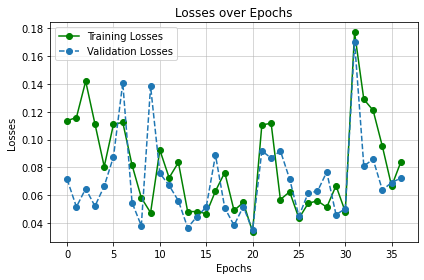

In [9]:
yankee.plotLosses()

In [22]:
%%time
zulu = CNNModel(
    depth=4,
    kernel_size=4,
    filters=46,
    activation=LeakyReLU()
)
zulu.describe()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 180, 180, 46)      782       
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 92)        67804     
                                                                 
 pool1 (MaxPooling2D)        (None, 45, 45, 92)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 184)       271032    
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 184)       0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 368)         1083760   
                                                                 
 pool3 (MaxPooling2D)        (None, 3, 3, 368)       

In [ ]:
zulu.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=15,
    showProgress=True
)
zulu.plotLosses()
zulu.evaluate()

Epoch 1/15
34/68 [==============>...............] - ETA: 22s - loss: 1.3766 - accuracy: 0.2684

In [21]:
zulu.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor            21                 8        58               13
1  meningioma_tumor             5                23        70               17
2          no_tumor            11                16        71                7
3   pituitary_tumor            13                12        19               30

Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.21      0.28       100
           1       0.39      0.20      0.26       115
           2       0.33      0.68      0.44       105
           3       0.45      0.41      0.43        74

    accuracy                           0.37       394
   macro avg       0.40      0.37      0.35       394
weighted avg       0.39      0.37      0.35       394



### 5. Are you overfitting? Verify. 

* As seen in the plots and the training info in the above section 1.4 the  
following models seem to be overfitting:
    
    1. india

### 6. Can you apply additional techniques to improve the performance of your CNN? Dropout? Data-augmentation, etc.. 

#### 7. Extra credits for nice plots and great analytics!  training_history.history.keys()

In [36]:
BaseModel.history()

AttributeError: 'CNNModel' object has no attribute 'history'

## Phase 2
---

### 1. Extract filters of your CNN from different layers. Convert them into images. What do they mean? 

* Inspection of the filters and the  feature map outputs of the convolution  
layers allow us to understand what features are exactly being detected  
for a given input image.

In [22]:
BaseModel = CNNModel()

###################################
# Filters of convolutional layers #
###################################



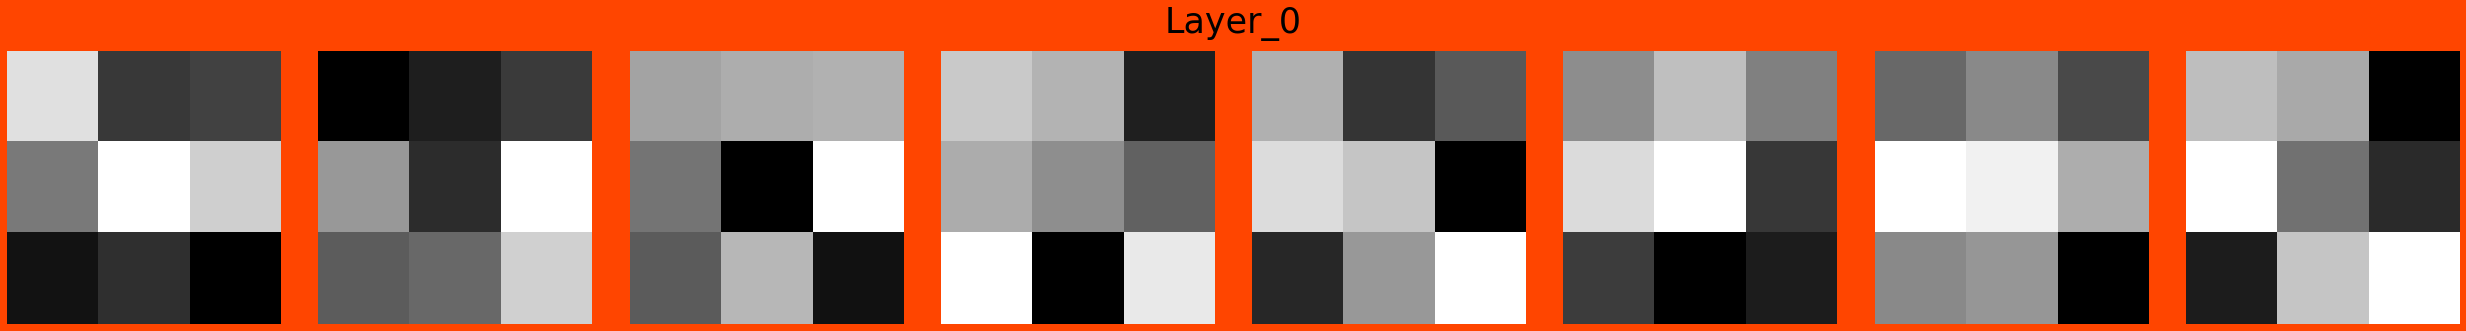

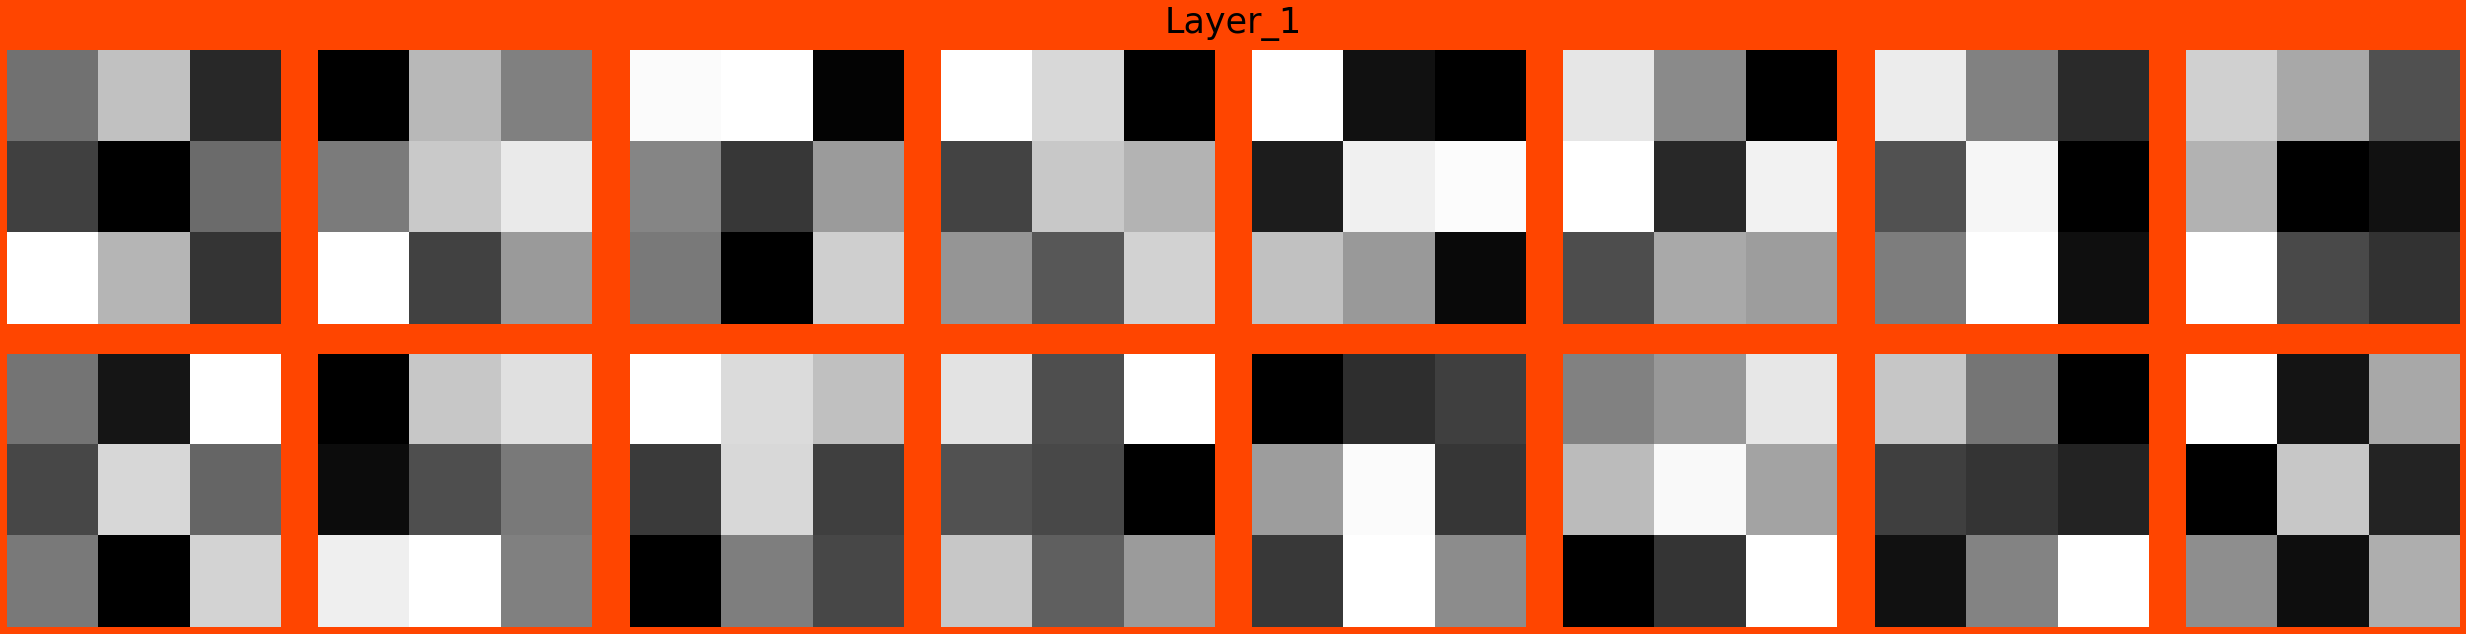

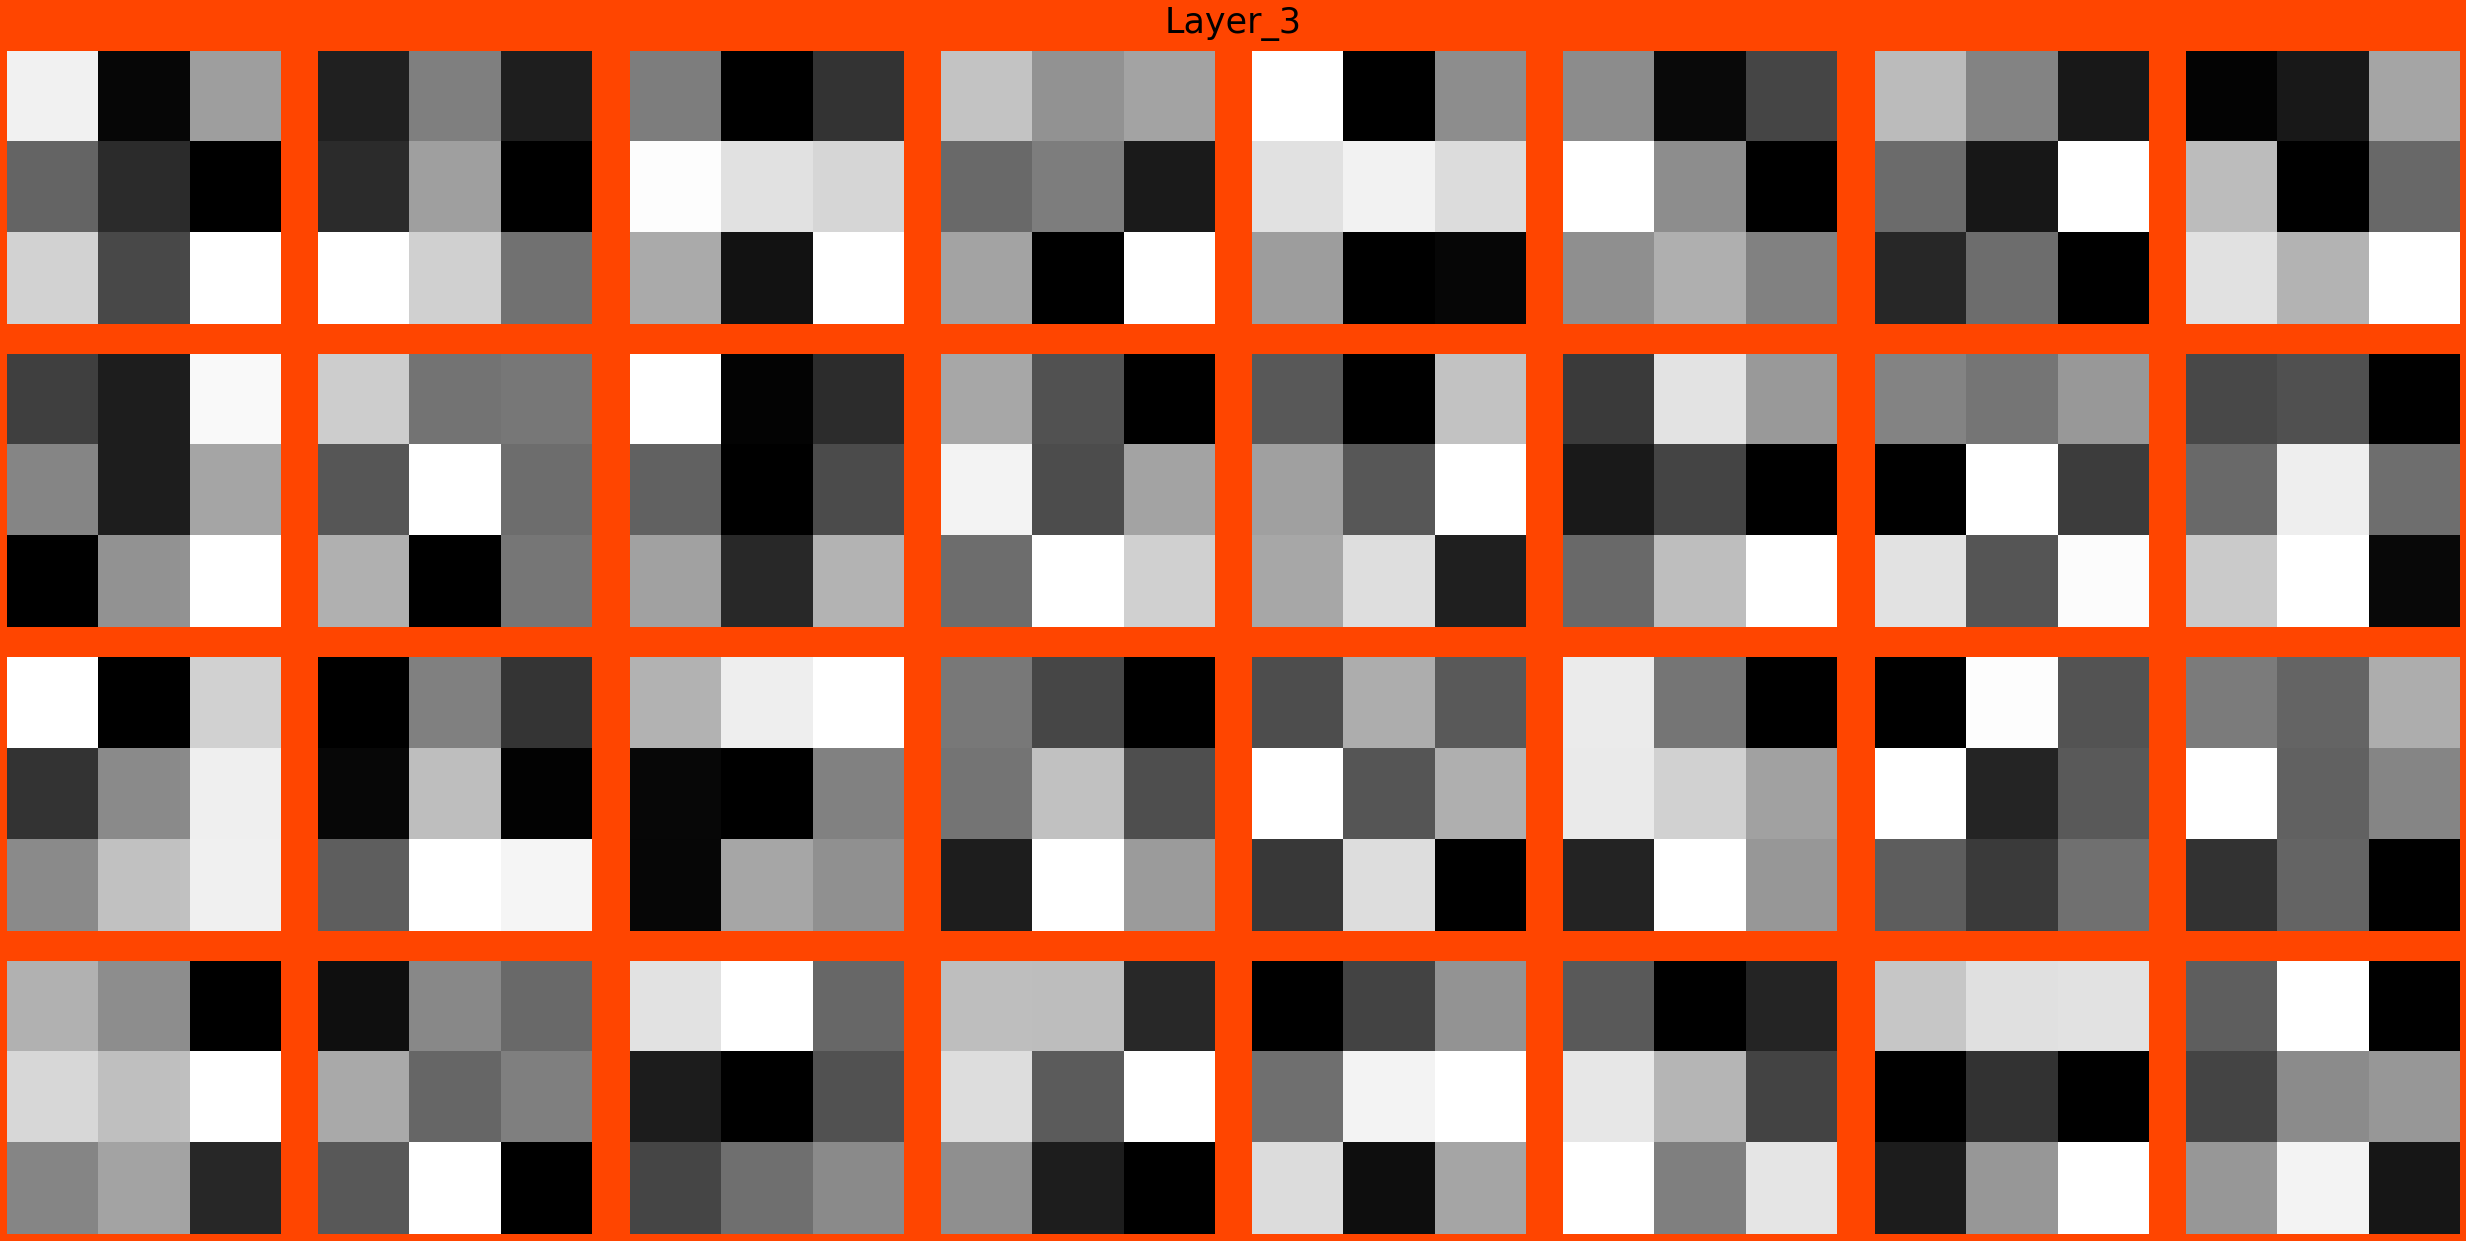

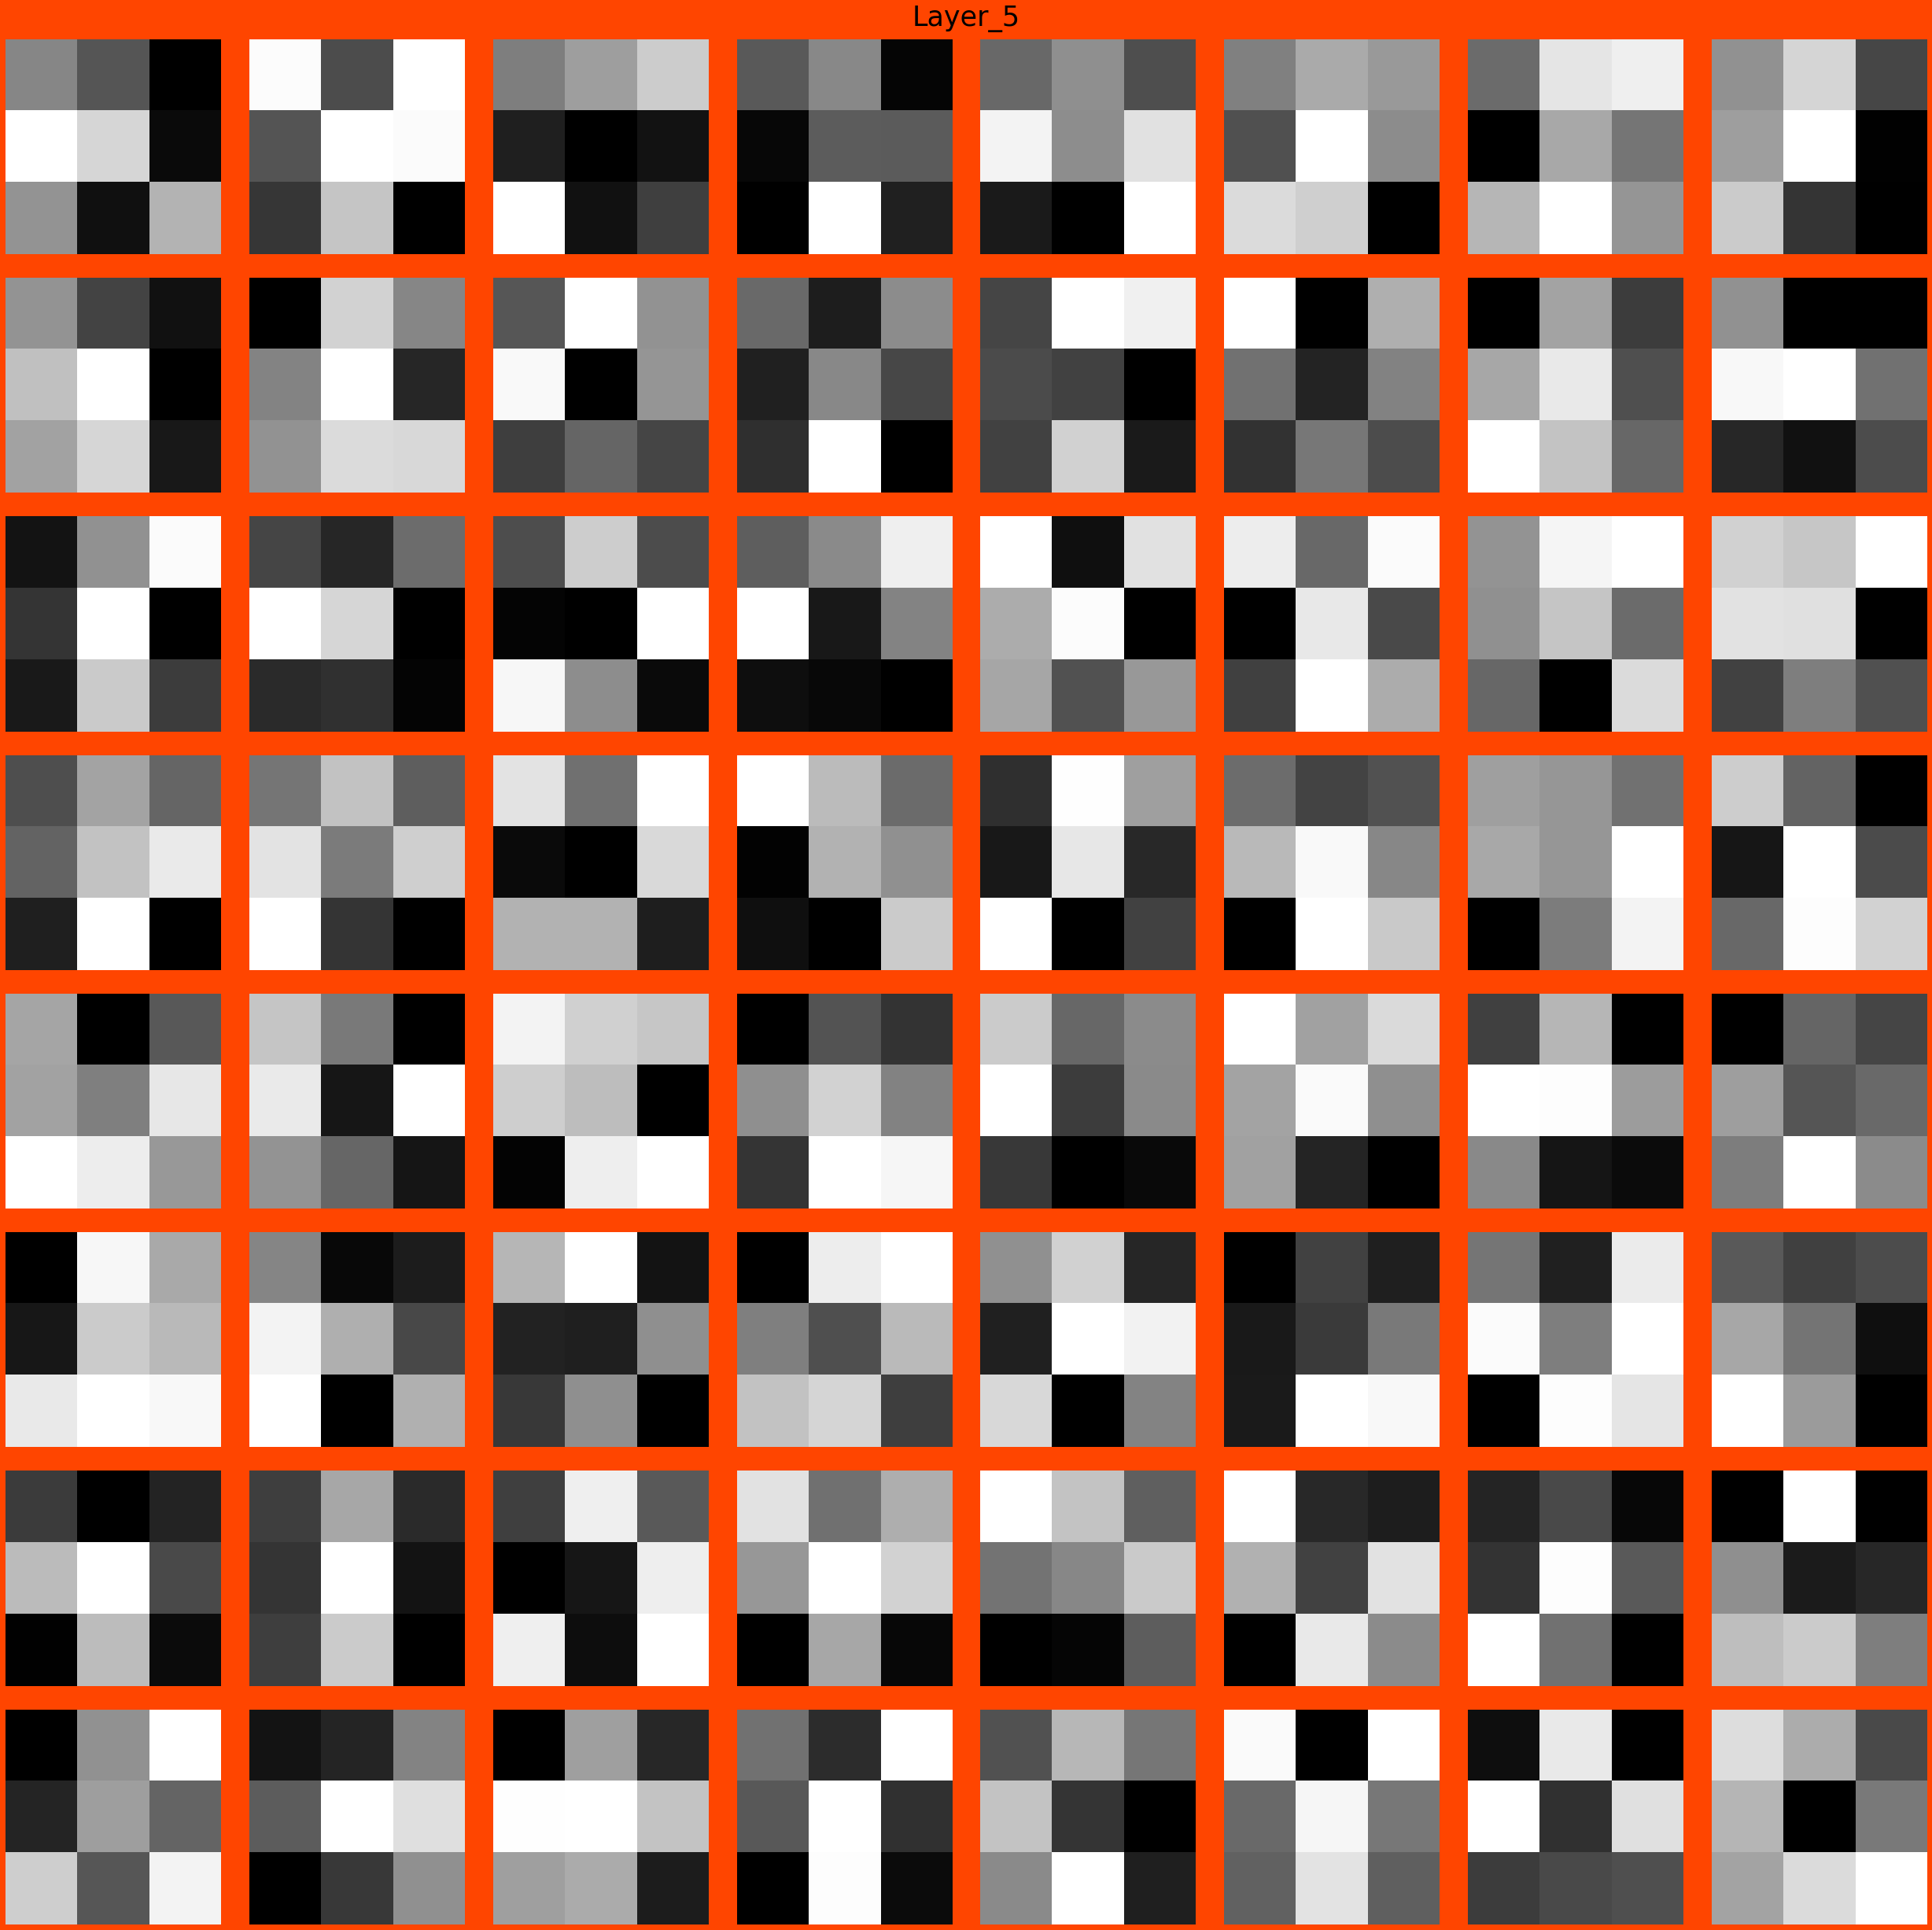

In [23]:
BaseModel.extractFilters()

* We can see that each layer has a different filter. This means each layer  
is looking for a different feature in the image. The features are traced by  
the brighter pixels in the filtres, for example the, third-last column in  
the last row is look for a feature that somewhat looks like the letter 'T'.

* Looking at just the filters is not that intuitive, so we'll now visualize  
the result of applying these filters to the input.

meningioma_tumor


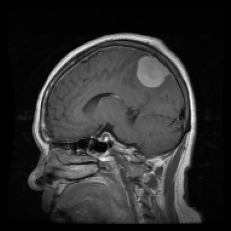

In [20]:
# Here's a random input
img = tumours.getRandomImage(printLabel=True)
pyplot.imshow(img, cmap='gray')
pyplot.axis('off')
pyplot.gcf().set_facecolor('black')

####################################
# Features of convolutional layers #
####################################



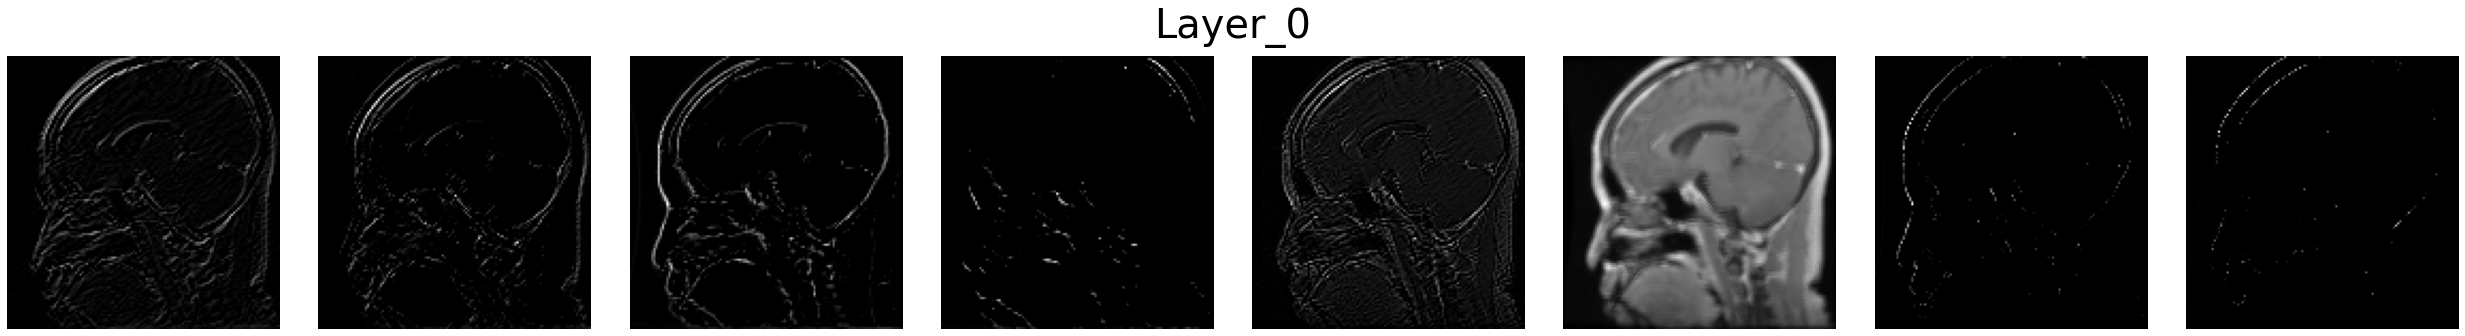

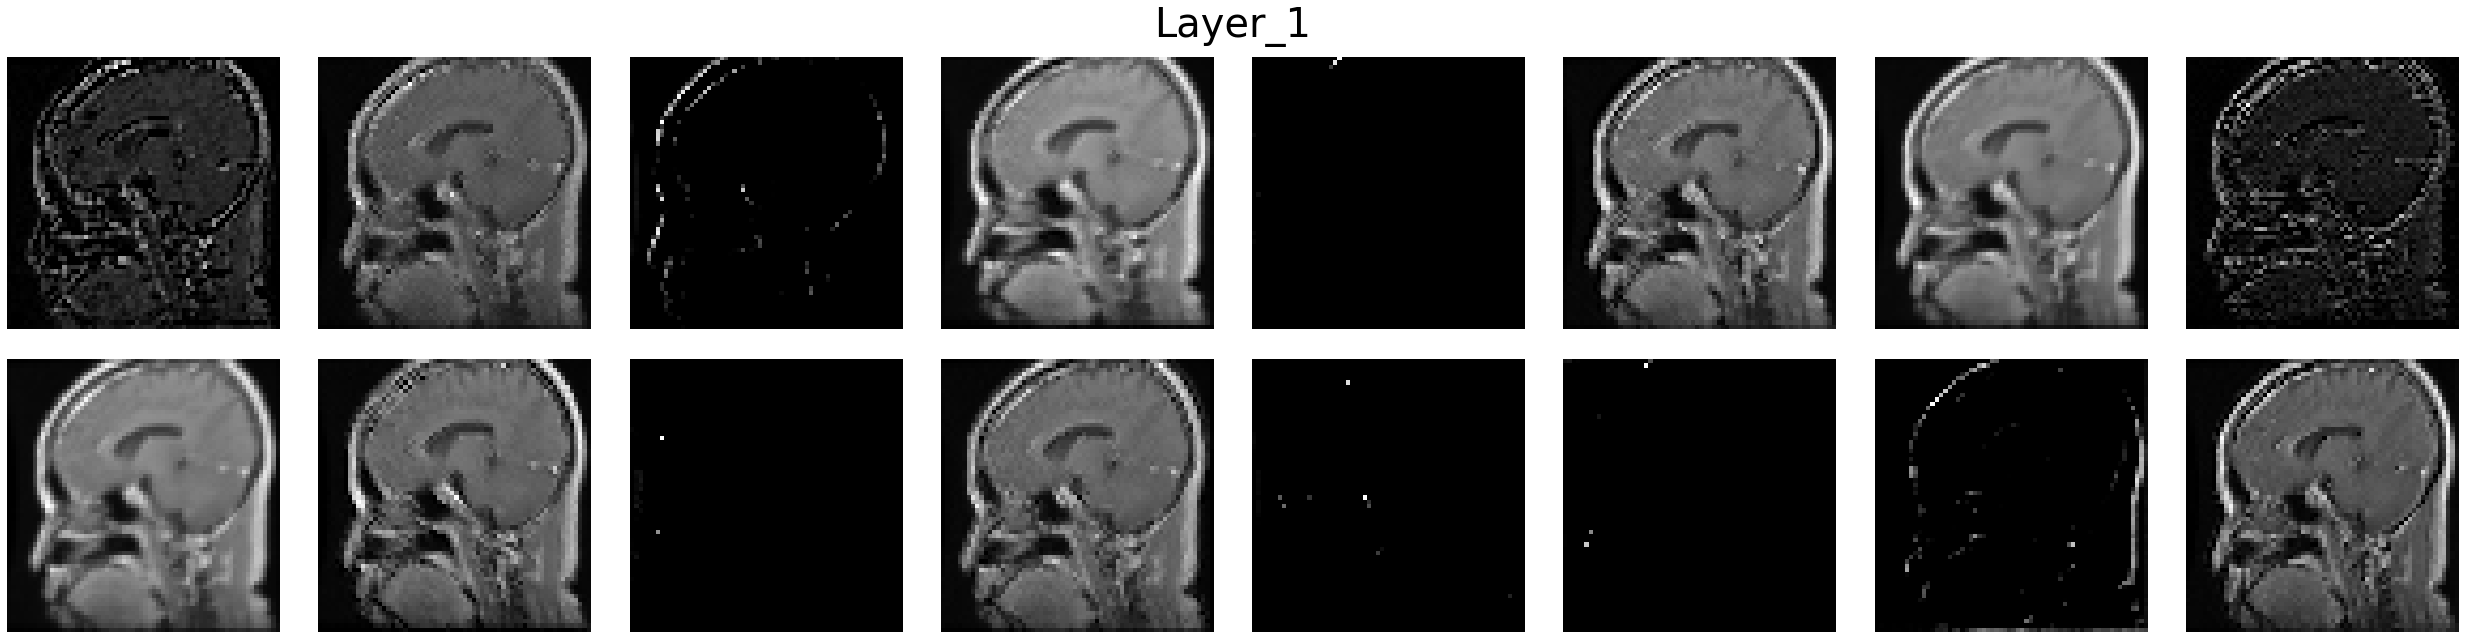

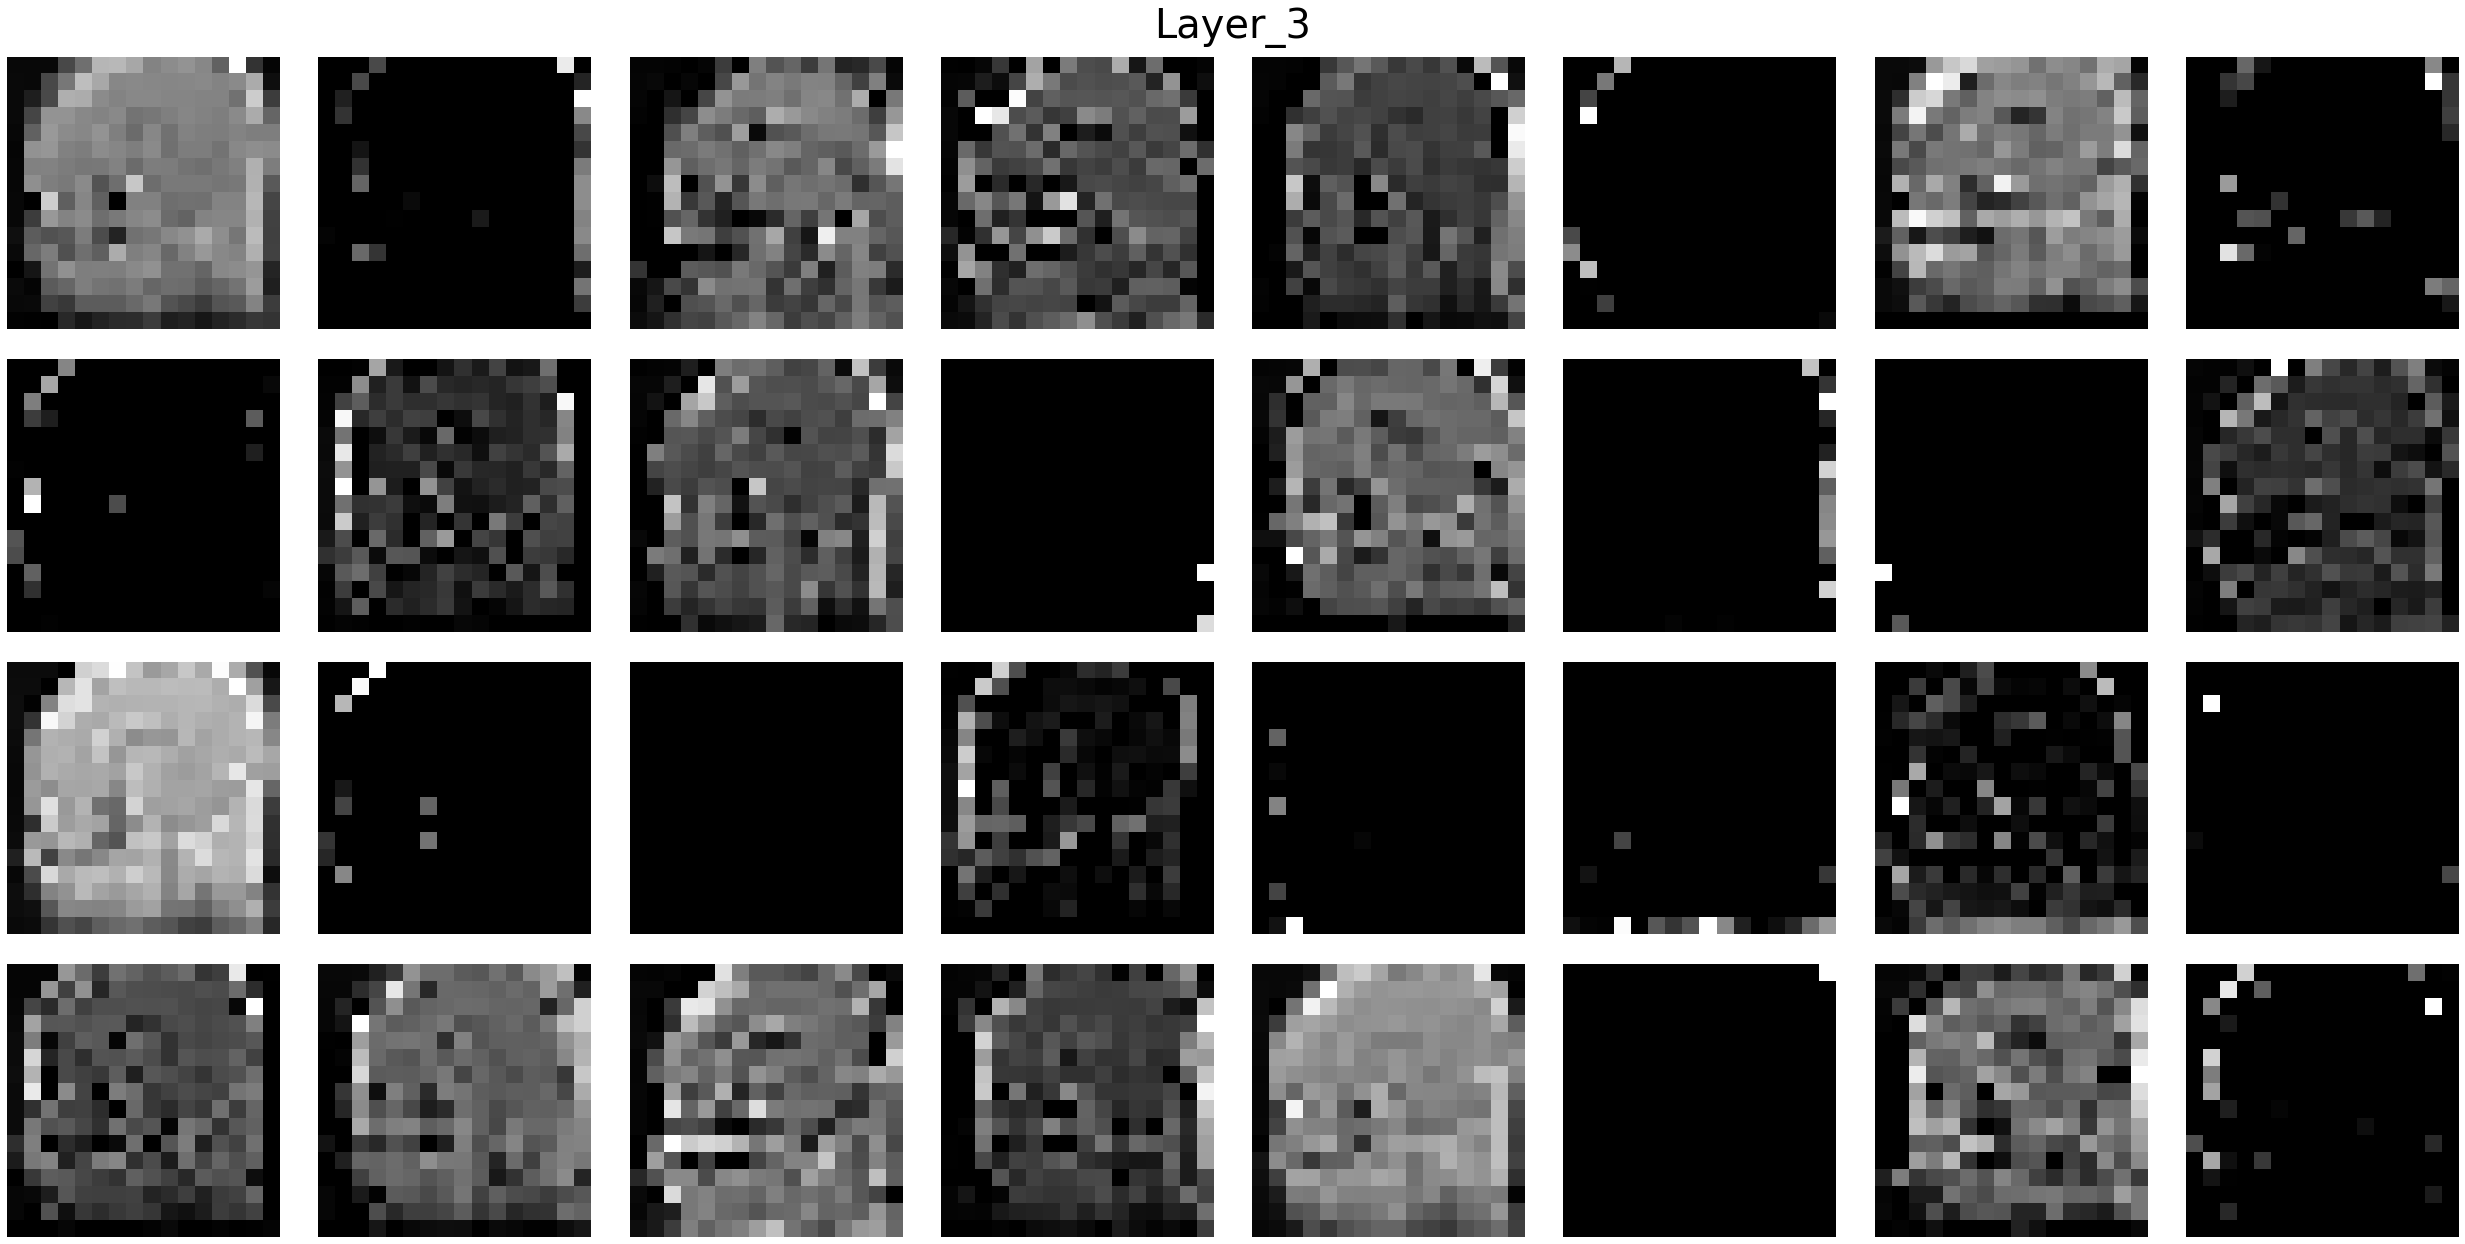

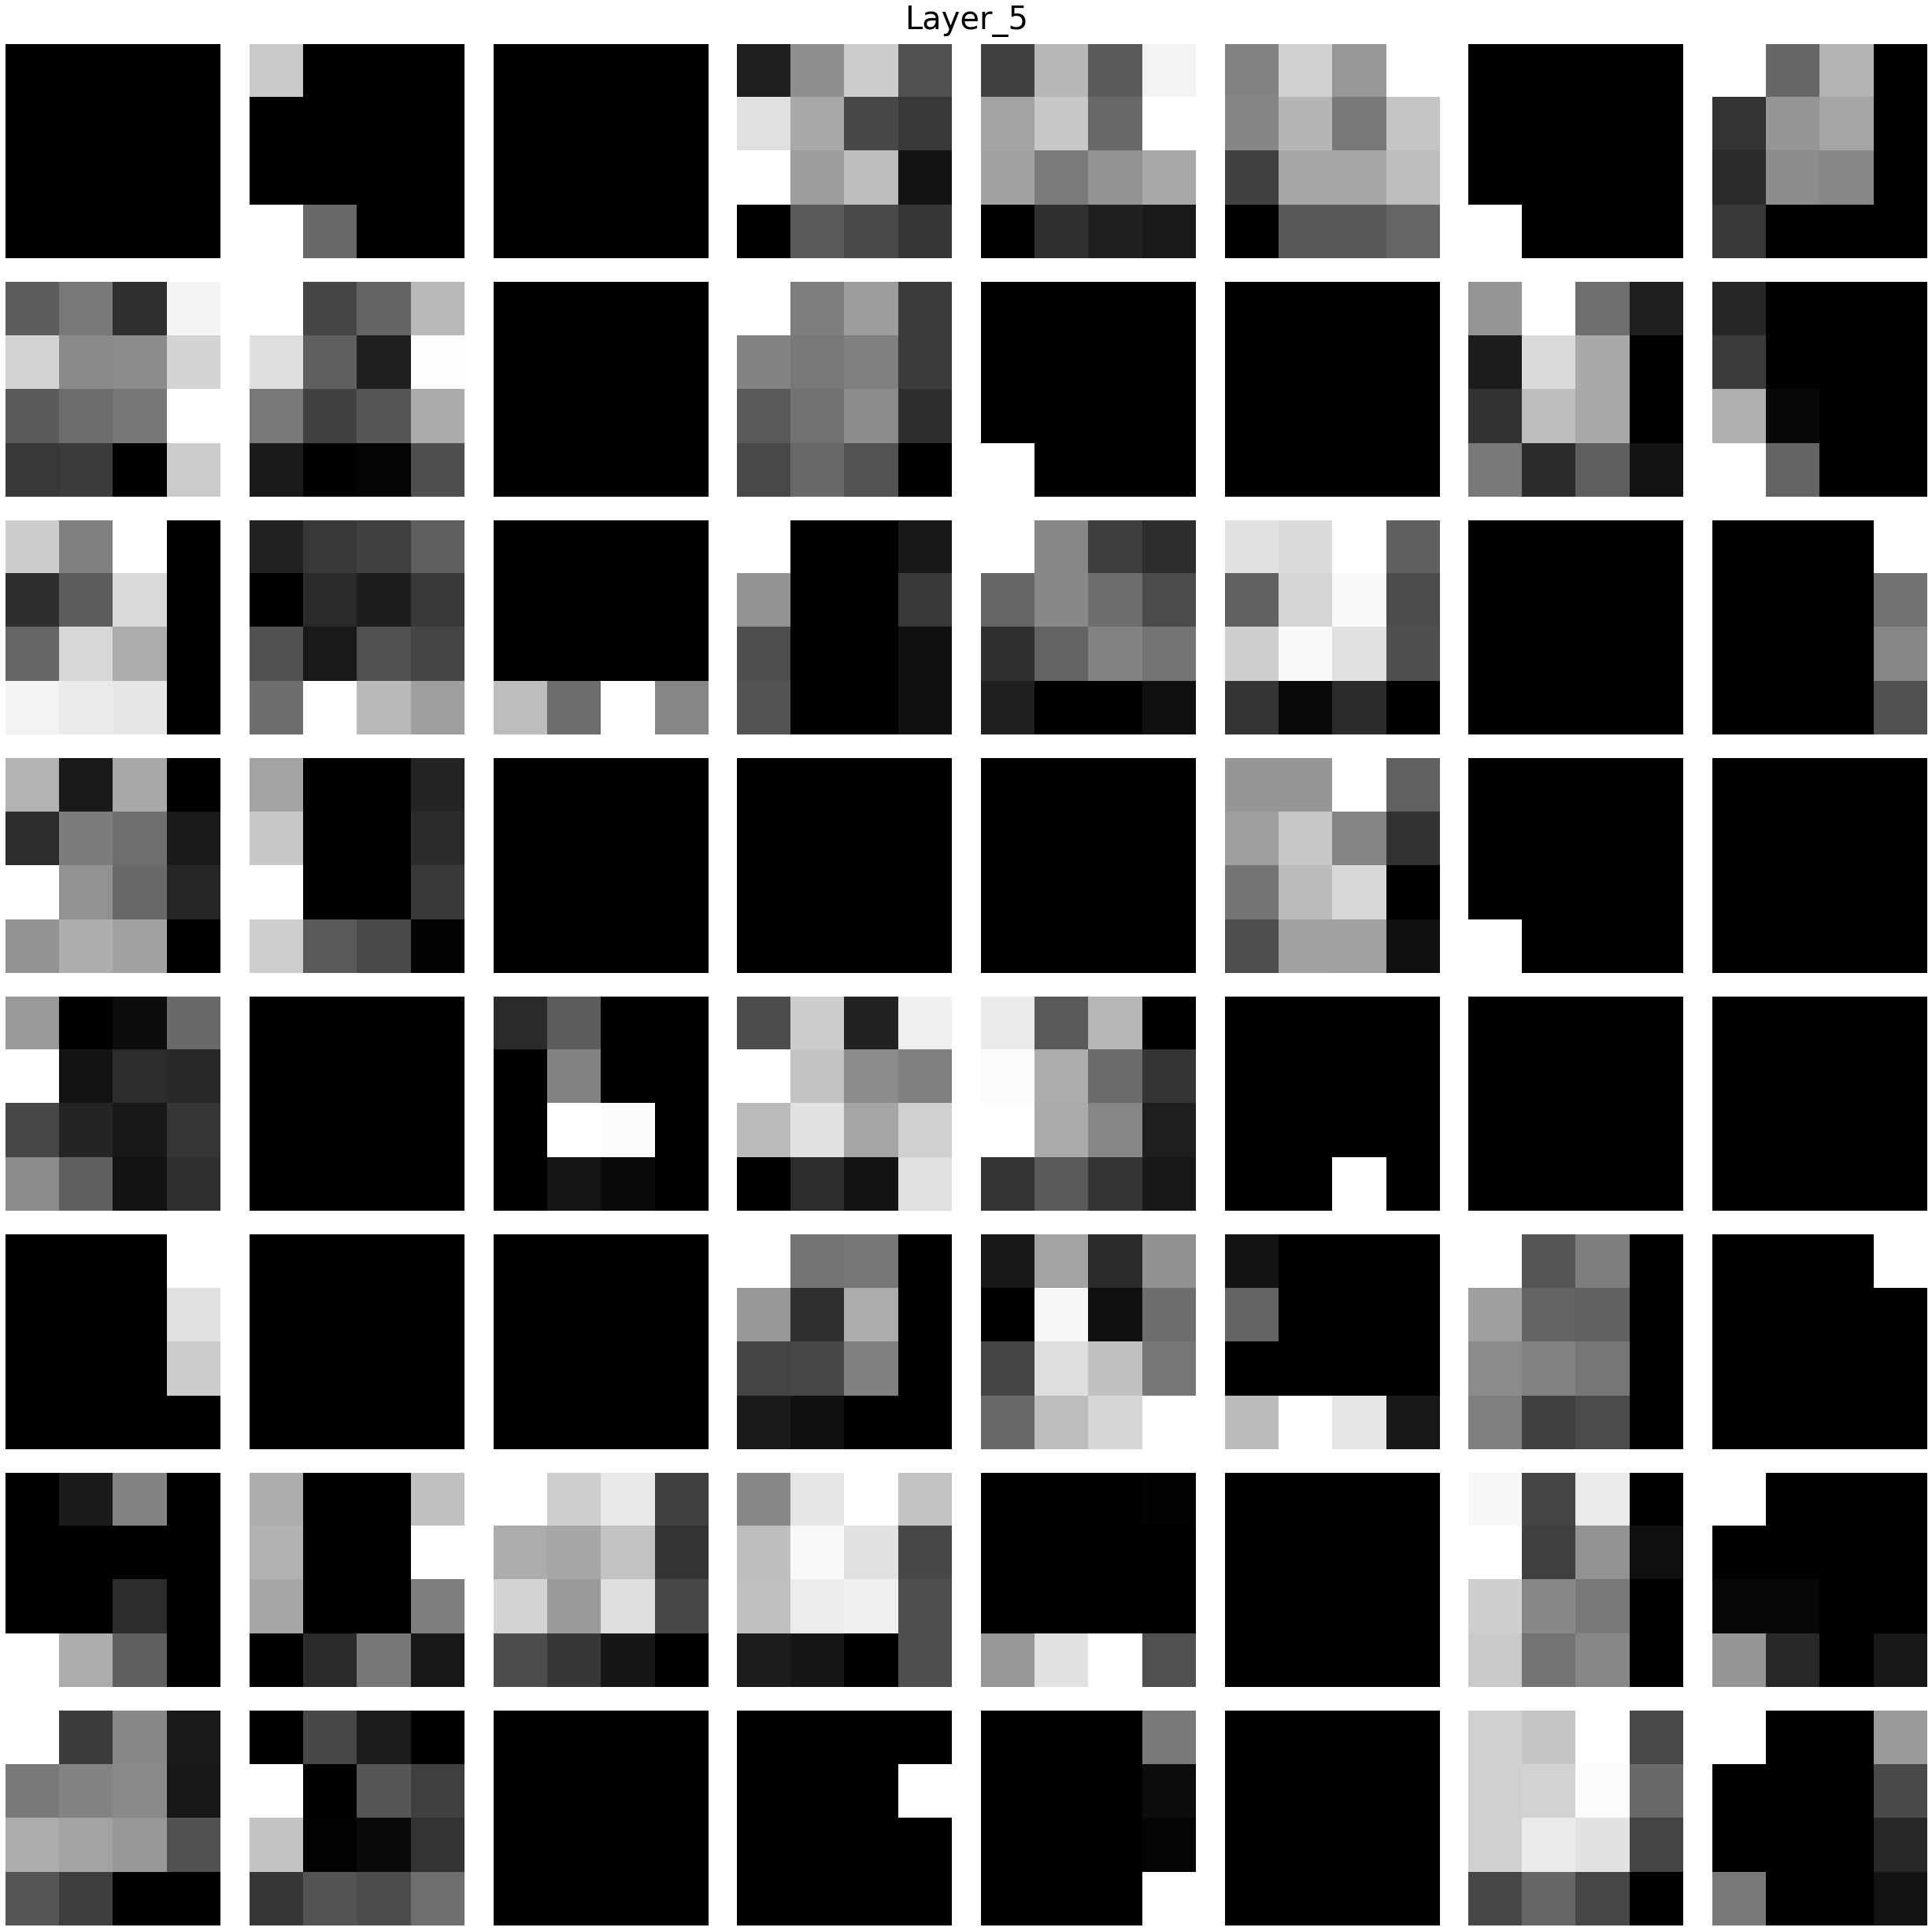

In [102]:
BaseModel.displayFeatureMaps(layer_instance='conv', image=img)

## Report

##### Runtime env

In [184]:
%%bash
python --version
neofetch | grep 'CPU\|GPU'

Python 3.10.4
CPU: Intel i7-8550U (8) @ 4.000GHz 
GPU: NVIDIA GeForce 940MX 
GPU: Intel UHD Graphics 620 


##### Summary chart

### > * First row is the Base Model.
> * All images are grayscaled.

| #parameters | #epochs | depth | Batch_size | filters |strides| kernel_size| Acitvation | Optimizer | learning_rate | val_f1t |
|:-----------:|:-------:|:-----:|:----------:|:-------:|:-----:|:----------:|------------|:---------:|:-------------:|:-------:|
| 26k         | 10      | 3     | 32         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |
| 26k         | 10      | 3     | 16         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.80    |
| 26k         | 10      | 3     | 8          | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.81    |
| 26k         | 10      | 3     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.75    |
| 22k         | 20      | 2     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |
| 22k         | 25      | 2     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |
| 101k        | 10      | 3     | 100        | 16      |1      | 3          | ReLU       | Adam      | 0.001         | 0.70    |
| 1.5M        | 10      | 3     | 32         | 64      |2      | 3          | ReLU       | Adam      | 0.001         | 0.85    |
| 1.5M        | 20      | 3     | 32         | 64      |2      | 3          | ReLU       | Adam      | 0.001         | 0.89    |
| 1.5M        | 20      | 3     | 32         | 64      |3      | 3          | ReLU       | Adam      | 0.001         | 0.84    |